# Discrete Wavelet Transform 

> Sandbox

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from pathlib import Path
from tqdm import tqdm
import re

import fastcore.all as fc
import pandas as pd

import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.spatial import ConvexHull
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter

from scipy.sparse import diags
from scipy.sparse.linalg import spsolve

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

import pywt

import matplotlib.pyplot as plt

In [ ]:
from lssm.loading import load_ossl, load_mir_kex_spike, load_nir_kex_spike
from lssm.visualization import plot_spectra
from sklearn.pipeline import Pipeline
from lssm.preprocessing import SpikeMean, MeanCenter

pd.set_option('display.max_rows', 500)

## Config

In [ ]:
scan_type = 'nir'

if scan_type == 'mir':
    src_dir = Path().home() / 'pro/data/k-spiking/mir'
    X, wavenumbers, names = load_mir_kex_spike(src_dir)
    ascending = False
else:
    fname = Path().home() / 'pro/data/k-spiking/nir/2023-12-8 _FT-NIR-K-spiked soil.xlsx'
    X, wavenumbers, names = load_nir_kex_spike(fname)
    ascending = True

In [ ]:
# Mean replicates
X_mean, names_mean = SpikeMean(names).fit_transform(X)

# Mean center
X_mean = MeanCenter().fit_transform(X_mean)

print(f'X shape: {X_mean.shape}')
print(f'Sample names: {names_mean}')

X shape: (12, 949)
Sample names: ['LUI-0' 'LUI-1' 'LUI-2' 'LUI-3' 'SPA1-0' 'SPA1-1' 'SPA1-2' 'SPA1-3'
 'TM4.1-0' 'TM4.1-1' 'TM4.1-2' 'TM4.1-3']


In [ ]:
names_mean

array(['LUI-0', 'LUI-1', 'LUI-2', 'LUI-3', 'SPA1-0', 'SPA1-1', 'SPA1-2',
       'SPA1-3', 'TM4.1-0', 'TM4.1-1', 'TM4.1-2', 'TM4.1-3'], dtype='<U7')

In [ ]:
class SpikeDWT(BaseEstimator, TransformerMixin):
    def __init__(self, 
                 names, 
                 wavenumbers,
                 top_percentile=1,
                 levels=range(4, 9),
                 wavelet_name='db1'):
        fc.store_attr()
        self.data = {'level': [], 'smp_name': [],
                     'wavenumber': [], 'coeff': [],
                     'resolution': [] # in wavenumbers
                     }
        
    def _compute_coeffs(self, x):
        max_level = pywt.dwt_max_level(data_len=len(x), 
                                       filter_len=pywt.Wavelet(self.wavelet_name).dec_len)
        return pywt.wavedec(x, self.wavelet_name, level=max_level)

    def _idx_of_percentile(self, arr, percentile):
        threshold = np.percentile(arr, percentile)  
        top_indices = np.where(arr >= threshold)[0]
        return top_indices[np.argsort(arr[top_indices])[::-1]]
    
    def _get_upsampling_factor(self, signal_length, n_coeffs):
        return round((signal_length/n_coeffs) / 2) * 2
    
    def _get_wn(self, idx, signal_length, n_coeffs):     
        upsampling_factor = self._get_upsampling_factor(signal_length, n_coeffs)
        return self.wavenumbers[round(idx * (signal_length/n_coeffs))]
    
    def fit(self, X, y=None): return self
    
    def transform(self, X):
        # For each sample
        for idx_smp, name in enumerate(self.names):
            coeffs = self._compute_coeffs(X[idx_smp])
            # For each DWT decomposition level
            for idx_level in self.levels:
                n_coeffs = len(coeffs[idx_level])
                # For each coeff
                for idx in self._idx_of_percentile(coeffs[idx_level], 100 - self.top_percentile):
                    signal_length = len(X[idx_smp])
                    self.data['smp_name'].append(name)
                    self.data['level'].append(idx_level)
                    # self.data['wavenumber'].append(self._get_wn(idx, len(X[idx_smp]), n_coeffs))
                    self.data['wavenumber'].append(self._get_wn(idx, signal_length, n_coeffs))
                    self.data['coeff'].append(coeffs[idx_level][idx])
                    self.data['resolution'].append(2*self._get_upsampling_factor(signal_length, n_coeffs))
        return pd.DataFrame(self.data)

In [ ]:
df = SpikeDWT(names_mean, wavenumbers, top_percentile=100).fit_transform(X_mean)

In [ ]:
df.head()

,level,smp_name,wavenumber,coeff,resolution
0,4,LUI-0,3523.3090,0.593469,248
1,4,LUI-0,649.8933,0.110607,248
2,4,LUI-0,1847.4710,0.097373,248
3,4,LUI-0,889.0232,0.066439,248
4,4,LUI-0,1608.3410,0.051123,248


In [ ]:
df.drop_duplicates(subset='level')[['level', 'resolution']].set_index('level')

,resolution
level,
4,248
5,124
6,64
7,32
8,16


In [ ]:
df[(df['smp_name'] == 'LUI-0') & (df['level'] == 4)].sort_values('wavenumber')

,level,smp_name,wavenumber,coeff,resolution
1,4,LUI-0,649.8933,0.110607,248
3,4,LUI-0,889.0232,0.066439,248
8,4,LUI-0,1128.1530,0.006137,248
7,4,LUI-0,1367.2830,0.009055,248
4,4,LUI-0,1608.3410,0.051123,248
2,4,LUI-0,1847.4710,0.097373,248
6,4,LUI-0,2086.6010,0.022665,248
11,4,LUI-0,2325.7310,-0.035549,248
12,4,LUI-0,2564.8610,-0.095917,248
13,4,LUI-0,2803.9910,-0.128203,248


In [ ]:
df_selected = df[(df['smp_name'] == 'LUI-1') & (df['level'] == 4)].sort_values('wavenumber'); df_selected

,level,smp_name,wavenumber,coeff,resolution
425,4,LUI-1,649.8933,0.117331,248
428,4,LUI-1,889.0232,0.051693,248
432,4,LUI-1,1128.1530,0.008152,248
431,4,LUI-1,1367.2830,0.010185,248
427,4,LUI-1,1608.3410,0.055033,248
426,4,LUI-1,1847.4710,0.106748,248
430,4,LUI-1,2086.6010,0.023523,248
435,4,LUI-1,2325.7310,-0.039053,248
436,4,LUI-1,2564.8610,-0.101311,248
437,4,LUI-1,2803.9910,-0.133796,248


In [ ]:
df_selected['wavenumber'] = df_selected['wavenumber'].astype('int')

In [ ]:
df_selected[['wavenumber', 'coeff']].to_numpy()

array([[ 6.49000000e+02,  1.17330898e-01],
       [ 8.89000000e+02,  5.16932516e-02],
       [ 1.12800000e+03,  8.15204846e-03],
       [ 1.36700000e+03,  1.01849044e-02],
       [ 1.60800000e+03,  5.50331627e-02],
       [ 1.84700000e+03,  1.06748027e-01],
       [ 2.08600000e+03,  2.35225117e-02],
       [ 2.32500000e+03, -3.90530072e-02],
       [ 2.56400000e+03, -1.01310554e-01],
       [ 2.80300000e+03, -1.33796484e-01],
       [ 3.04300000e+03, -4.82046360e-03],
       [ 3.28400000e+03, -3.44090110e-02],
       [ 3.52300000e+03,  6.26064771e-01],
       [ 3.76200000e+03,  4.87345630e-02]])

In [ ]:
def dwt_coeffs(df, smp_name, level):
    df_selected = df[(df['smp_name'] == smp_name) & (df['level'] == level)].sort_values('wavenumber')
    df_selected['wavenumber'] = df_selected['wavenumber'].astype('int')
    data_selected = df_selected[['wavenumber', 'coeff']].to_numpy()
    return data_selected[:,0], data_selected[:,1]

In [ ]:
level = 6
smp_name = 'TM4.1'
idx = 0
wns, coeffs_0  = dwt_coeffs(df, f'{smp_name}-{idx}', level=level)
_, coeffs_1  = dwt_coeffs(df, f'{smp_name}-{idx + 1}', level=level)
_, coeffs_2  = dwt_coeffs(df, f'{smp_name}-{idx + 2}', level=level)
_, coeffs_3  = dwt_coeffs(df, f'{smp_name}-{idx + 3}', level=level)

plt.figure(figsize=(12,5))
plt.ylim(0, 0.03)
markerLines, stemLines, baseLines = plt.stem(wns, np.abs(coeffs_3 - coeffs_0))
plt.setp(markerLines, color = 'steelblue', markersize = 5,
            markeredgecolor = 'white', markeredgewidth = 1)
plt.setp(stemLines, color = 'steelblue', linewidth = 1.5, linestyle = '-')
plt.setp(baseLines, color = 'white', linewidth = 2, linestyle  = '--')
plt.margins(0.1, 0.1)
# plt.title('Difference between dwt coeffs')
# plt.ylabel('valeurs')

NameError: name 'df' is not defined

In [ ]:
names_mean

array(['LUI-0', 'LUI-1', 'LUI-2', 'LUI-3', 'SPA1-0', 'SPA1-1', 'SPA1-2',
       'SPA1-3', 'TM4.1-0', 'TM4.1-1', 'TM4.1-2', 'TM4.1-3'], dtype='<U7')

In [ ]:
def delta_w(s1, s2): return np.sum(np.square(s1 - s2))

idx_smp = 0
for i in [1, 2, 3]:     
    # print(delta_w(X_mean[idx_smp,:], X_mean[idx_smp+i,:]))
    print(np.dot(X_mean[idx_smp,:], X_mean[idx_smp+i,:]))

2.506058592496409
2.3542213985543885
2.3802947286392815


<matplotlib.legend.Legend>

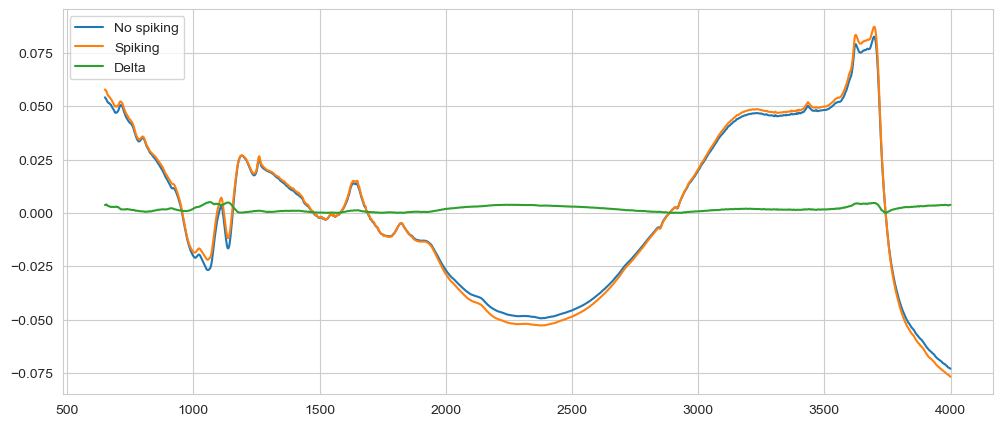

In [ ]:
plt.figure(figsize=(12,5))

# Plot the first signal
plt.plot(wavenumbers, X_mean[0,:], label='No spiking')
plt.plot(wavenumbers, X_mean[1,:], label='Spiking')
plt.plot(wavenumbers, np.abs(X_mean[1,:] - X_mean[0,:]), label='Delta')
# plt.plot(wavenumbers, np.abs(X_mean[2,:] - X_mean[0,:]), label='Delta-1')
# plt.plot(wavenumbers, np.abs(X_mean[3,:] - X_mean[0,:]), label='Delta-10')
plt.legend()

<Figure size 640x480 with 0 Axes>

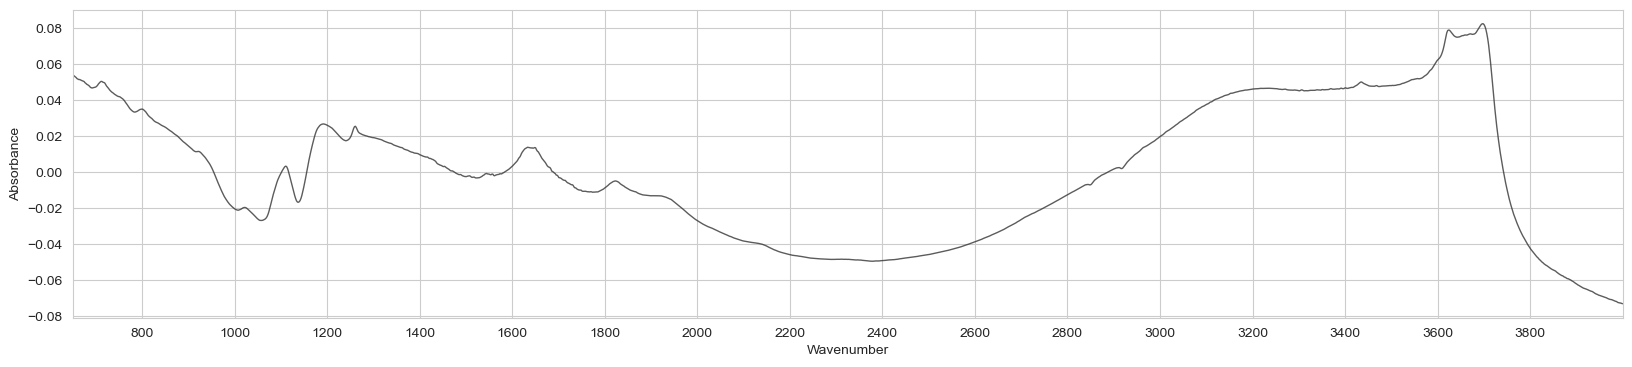

In [ ]:
plot_spectra(X_mean[0,:], wavenumbers, ascending=True)

<Figure size 640x480 with 0 Axes>

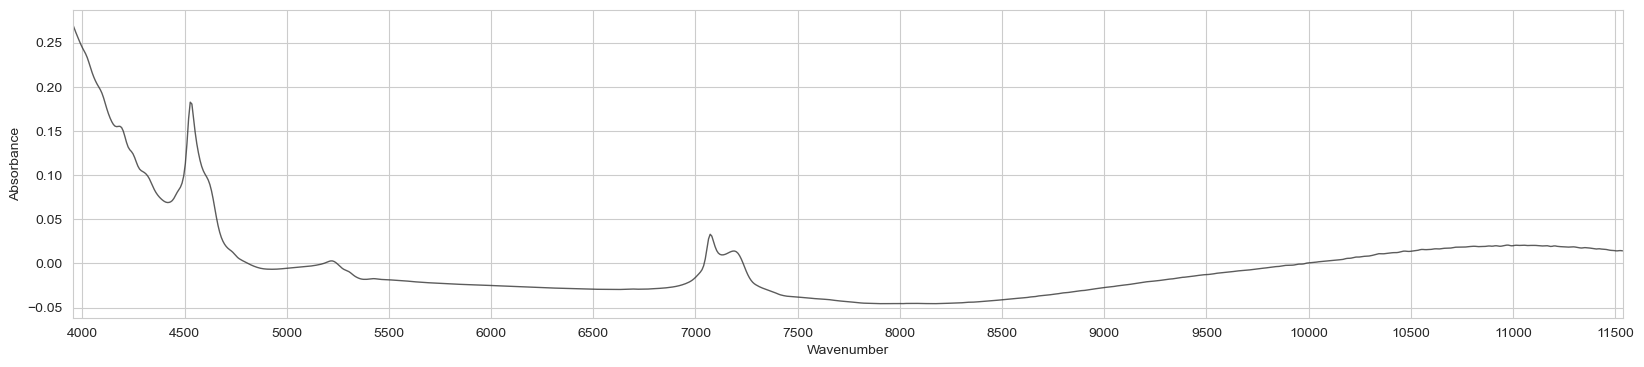

In [ ]:
plot_spectra(X_mean[3,:], wavenumbers, ascending=True)

In [ ]:
fname = Path.home() / f'pro/data/tmp/{scan_type}-dwt.csv'
df.to_csv(fname)

In [ ]:
df_spectra = pd.DataFrame(X_mean)
df_spectra.index = names_mean
df_spectra.index.name = 'smp_name'
df_spectra.columns = [round(w) for w in wavenumbers]

In [ ]:
df_spectra.head()

,650,652,654,656,658,660,661,663,665,667,...,3982,3984,3986,3988,3990,3992,3994,3996,3998,4000
smp_name,,,,,,,,,,,,,,,,,,,,,
LUI-0,0.054167,0.053755,0.053535,0.053057,0.052675,0.052091,0.051808,0.051546,0.051570,0.051309,...,-0.071488,-0.071687,-0.071794,-0.072081,-0.072417,-0.072553,-0.072626,-0.072718,-0.072912,-0.073066
LUI-1,0.057876,0.057394,0.057375,0.057018,0.056313,0.055536,0.055090,0.054728,0.054729,0.054367,...,-0.075179,-0.075363,-0.075494,-0.075681,-0.075907,-0.076111,-0.076215,-0.076326,-0.076638,-0.076836
LUI-2,0.057466,0.057137,0.057162,0.057165,0.056660,0.055979,0.055766,0.055335,0.055126,0.054921,...,-0.073488,-0.073662,-0.073879,-0.074149,-0.074321,-0.074424,-0.074614,-0.074765,-0.074936,-0.075108
LUI-3,0.061333,0.060895,0.060628,0.060180,0.059536,0.058961,0.058500,0.058108,0.057927,0.057727,...,-0.073068,-0.073243,-0.073433,-0.073631,-0.073898,-0.074076,-0.074120,-0.074232,-0.074522,-0.074571
SPA1-0,0.080840,0.079411,0.079227,0.078478,0.077580,0.076130,0.075691,0.074919,0.074988,0.074399,...,-0.083016,-0.083091,-0.083177,-0.083211,-0.083304,-0.083430,-0.083468,-0.083532,-0.083562,-0.083269


In [ ]:
df_spectra = df_spectra.reset_index().melt(id_vars='smp_name', 
                                           var_name='wavenumber', 
                                           value_name='absorbance')

## export

In [ ]:
fname = Path.home() / f'pro/data/tmp/{scan_type}.csv'
# df_spectra.to_csv(fname, index=True, columns=wavenumbers)
df_spectra.to_csv(fname, index=False)

In [ ]:
df_spectra

,smp_name,wavenumber,absorbance
0,LUI-0,650,0.685624
1,LUI-1,650,0.692353
2,LUI-2,650,0.660839
3,LUI-3,650,0.715882
4,SPA1-0,650,0.684192
...,...,...,...
20851,SPA1-3,4000,0.559841
20852,TM4.1-0,4000,0.535861
20853,TM4.1-1,4000,0.398248
20854,TM4.1-2,4000,0.521571


In [ ]:
wavelet_name = 'db1'

signal_length = X.shape[-1]
sample_signal = X[mask_smp, :][1]
print(signal_length)

max_level = pywt.dwt_max_level(data_len=signal_length, filter_len=pywt.Wavelet(wavelet_name).dec_len)
coeffs = pywt.wavedec(sample_signal, wavelet_name, level=max_level)

1738


In [ ]:
for i, level in enumerate(coeffs):
    print(f'level: {i} | # coeffs: {len(level)} | max: {np.max(level):.3f} | argmax: {np.argmax(level)} | argmin: {np.argmin(level)}')     

level: 0 | # coeffs: 2 | max: 19.994 | argmax: 0 | argmin: 1
level: 1 | # coeffs: 2 | max: 0.904 | argmax: 0 | argmin: 1
level: 2 | # coeffs: 4 | max: 0.687 | argmax: 1 | argmin: 2
level: 3 | # coeffs: 7 | max: 0.399 | argmax: 6 | argmin: 4
level: 4 | # coeffs: 14 | max: 0.503 | argmax: 12 | argmin: 2
level: 5 | # coeffs: 28 | max: 0.222 | argmax: 24 | argmin: 5
level: 6 | # coeffs: 55 | max: 0.136 | argmax: 49 | argmin: 19
level: 7 | # coeffs: 109 | max: 0.066 | argmax: 99 | argmin: 19
level: 8 | # coeffs: 218 | max: 0.033 | argmax: 198 | argmin: 39
level: 9 | # coeffs: 435 | max: 0.012 | argmax: 396 | argmin: 156
level: 10 | # coeffs: 869 | max: 0.004 | argmax: 792 | argmin: 312


In [ ]:
round(1738 / 218 / 2) * 2

8

In [ ]:
198 * (8+4)

2376

In [ ]:
def indices_of_percentile(arr, percentile):
    threshold = np.percentile(arr, percentile)  
    top_indices = np.where(arr >= threshold)[0]
    return top_indices[np.argsort(arr[top_indices])[::-1]]

In [ ]:
indices_of_percentile(coeffs[-1], 98)

array([792, 793, 794, 791, 795, 796, 783, 360, 797, 361, 272, 359, 327,
       784, 326, 268, 362, 353])

In [ ]:
get_wn(10, signal_length, 476)

727.032

In [ ]:
len(coeffs[-1])

869

In [ ]:
869, 870, 871

In [ ]:
# 1       0  
# 1 1 1 1 0 0 0 0
* 4 + 4/2

In [ ]:
upsampling_factor = round((signal_lenxgth/len(coeffs[-2])) / 2) * 2; upsampling_factor

4

In [ ]:
upsampling_factor*(idx + 1/2)

In [ ]:
4*(235 + 1/2)

940

In [ ]:
def get_wn(idx, signal_length, n_coeffs): 
    upsampling_factor = round((signal_length/n_coeffs) / 2) * 2
    # return wavenumbers[idx * upsampling_factor + upsampling_factor/2]
    return wavenumbers[idx * upsampling_factor + int(upsampling_factor/2)]   

for idx_level in range(4,9):
    n_coeffs = len(coeffs[idx_level])
    print([get_wn(idx, signal_length, n_coeffs) for idx in indices_of_percentile(coeffs[idx_level], 95)])
    print([coeffs[idx_level][idx] for idx in indices_of_percentile(coeffs[idx_level], 95)])
    print(20*'-')

[3639.017]
[0.5030948871018521]
--------------------
[3579.235, 2024.89]
[0.22157291250000027, 0.11243541250000046]
--------------------
[3704.585, 2038.39, 1914.968]
[0.13567332056838308, 0.0817733283549792, 0.05940883133592417]
--------------------
[3720.013, 3658.302, 1899.54, 2053.817, 2022.962, 1714.407]
[0.06550110000000012, 0.025844025000000086, 0.025333974999999887, 0.024397299999999802, 0.02074159999999967, 0.016903050000000162]
--------------------
[3712.299, 2046.104, 3727.727, 1907.254, 3666.016, 2015.248, 3681.444, 703.8904, 1166.723, 2030.676, 1814.687]
[0.032855327679103284, 0.013433190364913302, 0.013366474840108358, 0.012190450196978, 0.01091355677151125, 0.010204646868032654, 0.009506944607035933, 0.008802666252974236, 0.007580326115676147, 0.007575199591512445, 0.006942727931080273]
--------------------


<Figure size 640x480 with 0 Axes>

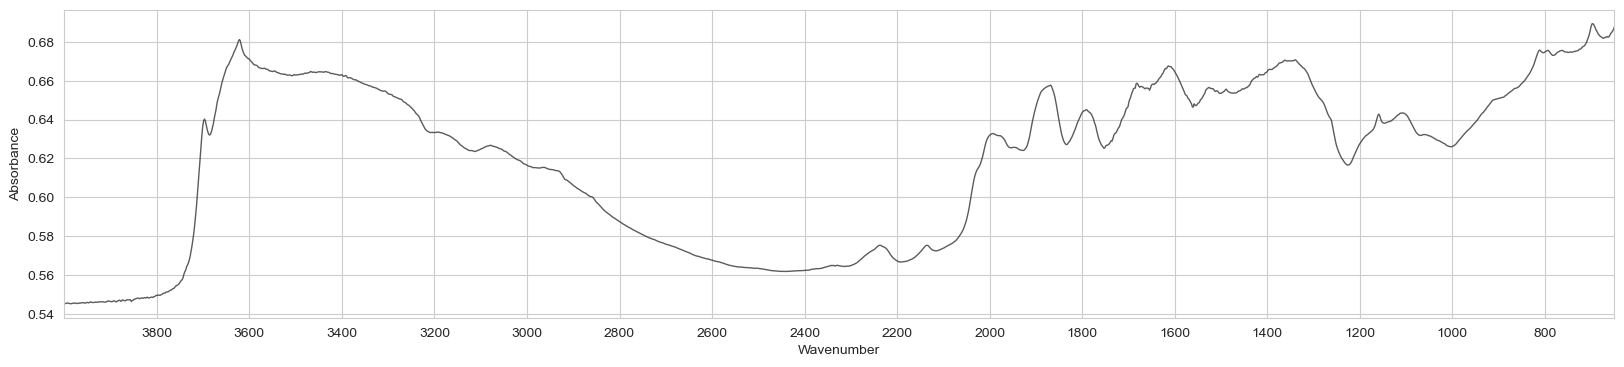

In [ ]:
plot_spectra(sample_signal, wavenumbers, ascending=False)

In [ ]:
kaolinite = [1e7 / i for i in [1395, 1415, 2165, 2207]]; print('kaolinite: ', kaolinite)
illite = [1e7 / i for i in [2207, 2345, 2450]]; print('illite: ', illite)
smectite = [1e7 / i for i in [1912, 2207, 2230]]; print('smectite', smectite)   

kaolinite:  [7168.458781362007, 7067.137809187279, 4618.937644341801, 4531.037607612143]
illite:  [4531.037607612143, 4264.392324093817, 4081.6326530612246]
smectite [5230.125523012553, 4531.037607612143, 4484.304932735426]


In [ ]:
cA, cD = pywt.dwt(sample_signal, 'db2')

[<matplotlib.lines.Line2D>]

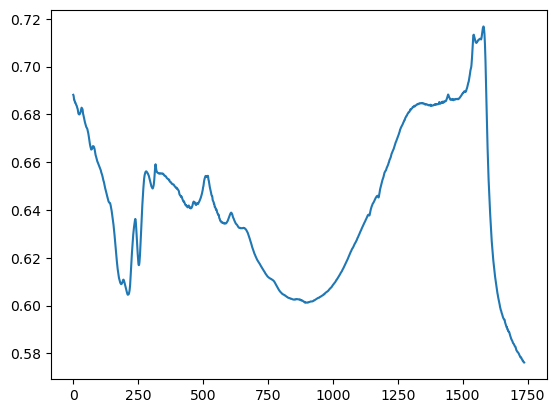

In [ ]:
plt.plot(range(len(sample_signal)), sample_signal)

[<matplotlib.lines.Line2D>]

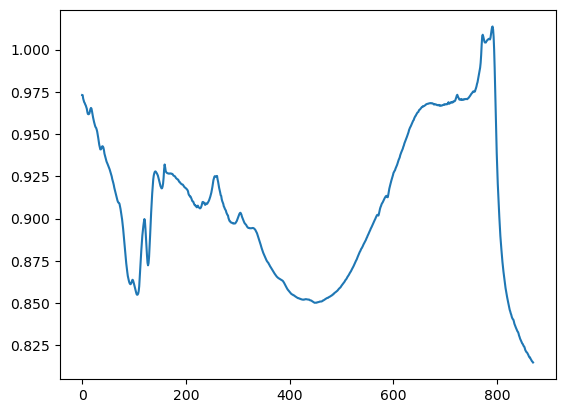

In [ ]:
plt.plot(range(len(cA)), cA)

[<matplotlib.lines.Line2D>]

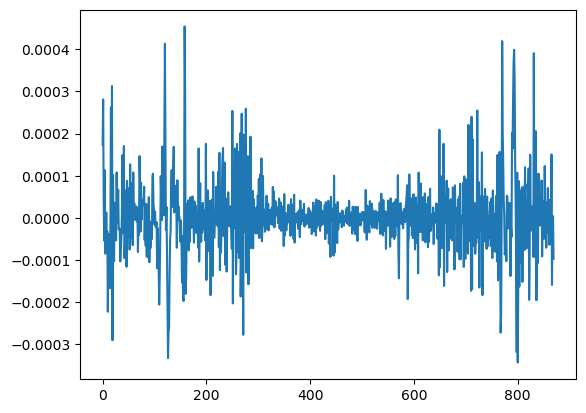

In [ ]:
plt.plot(range(len(cD)), cD)

In [ ]:
pywt.Wavelet('db3').dec_len

6

In [ ]:
2**7

128

In [ ]:
n_coeffs_selected = len([element for level in coeffs for element in level if element > 0.01])
print(n_coeffs_selected)
100 * n_coeffs_selected / X.shape[-1]


47


4.952581664910432

In [ ]:
# for coeff in coeffs: print(coeff)

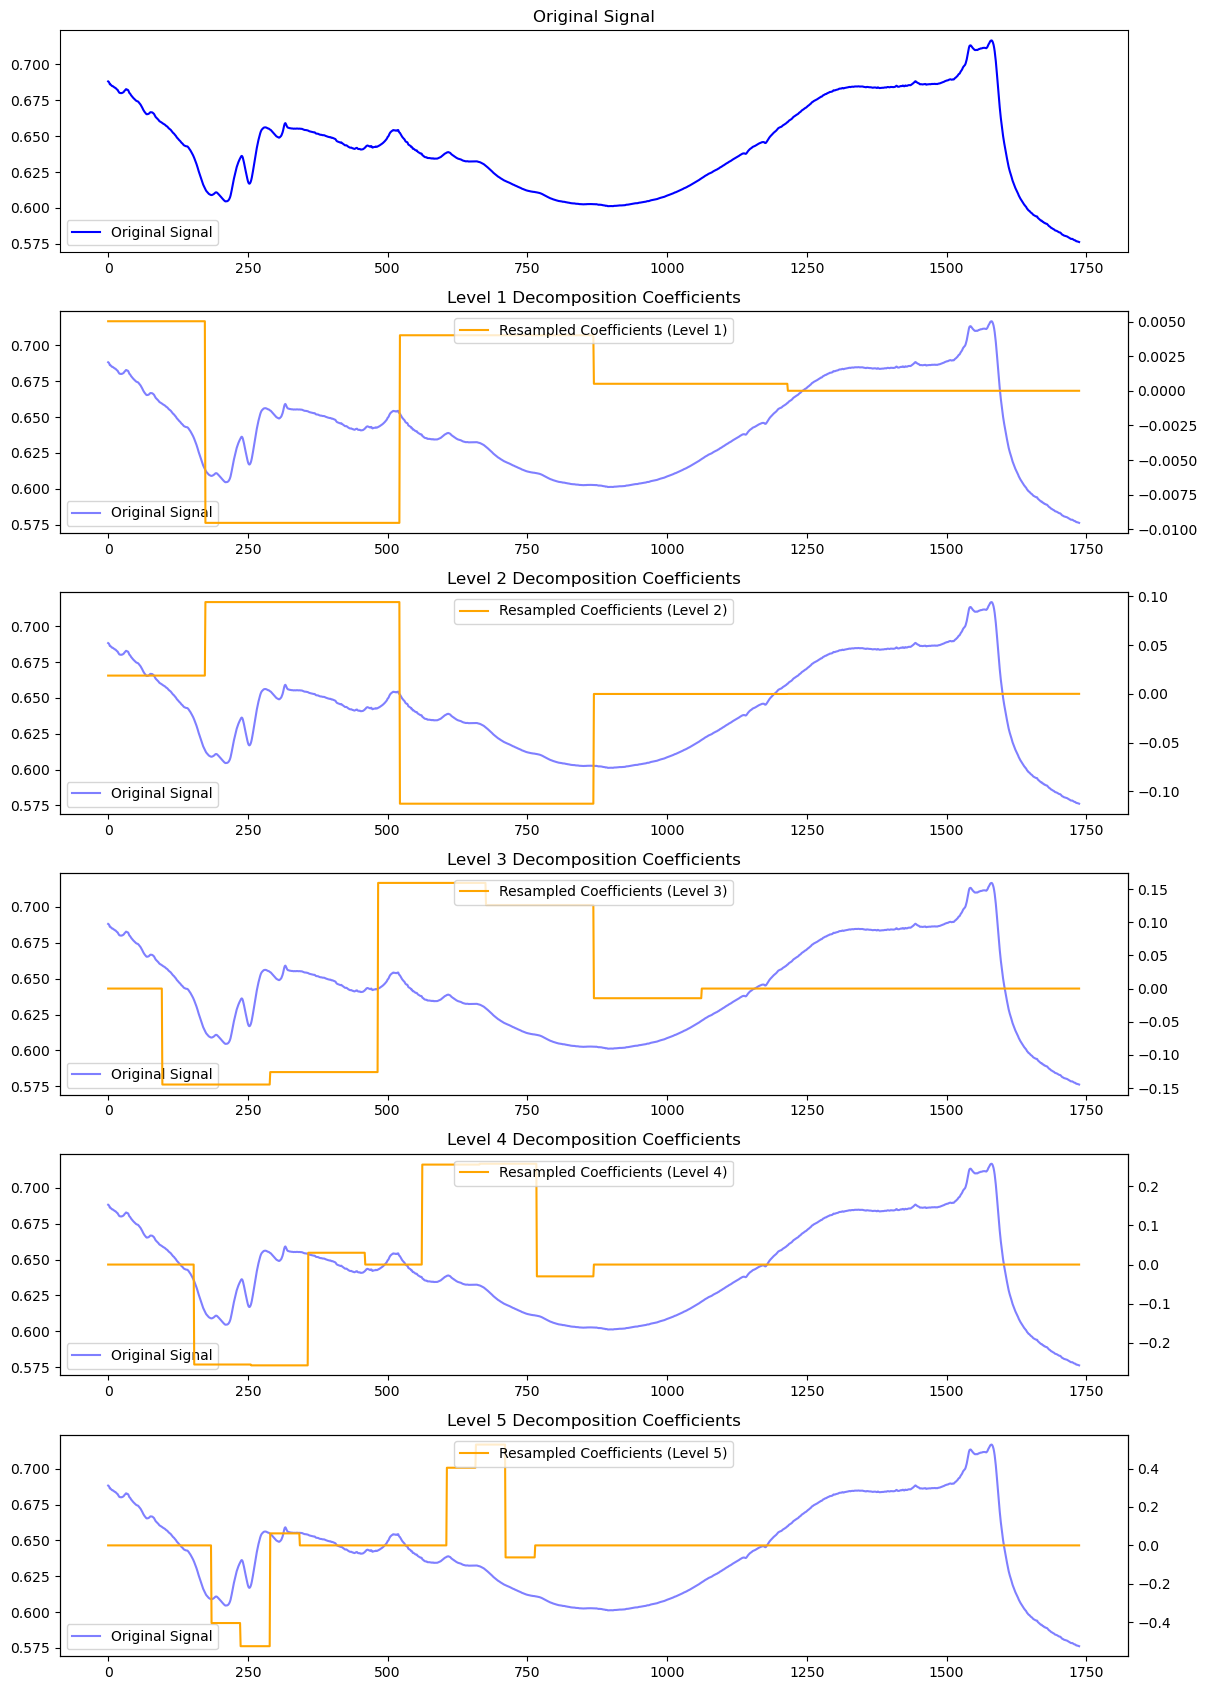

In [ ]:
# Creating a new figure for plotting with separate y-axis scales for the original signal and coefficients
plt.figure(figsize=(12, max_level * 3 + 2))

# Plot the original signal
plt.subplot(max_level + 1, 1, 1)
plt.plot(sample_signal, label='Original Signal', color='blue')
plt.title('Original Signal')
plt.legend(loc='lower left')

# Iterate through each level of decomposition
for level in range(max_level):
    # Extracting the coefficients
    cA = coeffs[level]

    # Interpolate the coefficients to the length of the original signal
    x_scale = np.linspace(0, signal_length - 1, len(cA))
    interp_cA = interp1d(x_scale, cA, kind='nearest', fill_value='extrapolate')
    cA_resampled = interp_cA(np.arange(signal_length))

    # Plotting the original signal and resampled coefficients on separate y-axes
    ax1 = plt.subplot(max_level + 1, 1, level + 2)
    ax2 = ax1.twinx()

    ax1.plot(sample_signal, label='Original Signal', color='blue', alpha=0.5)
    ax2.plot(cA_resampled, label=f'Resampled Coefficients (Level {level + 1})', color='orange')

    ax1.set_title(f'Level {level + 1} Decomposition Coefficients')
    ax1.legend(loc='lower left')
    ax2.legend(loc='upper center')

plt.tight_layout()
plt.show()


In [ ]:
np.zeros(10)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

## Toy example

4


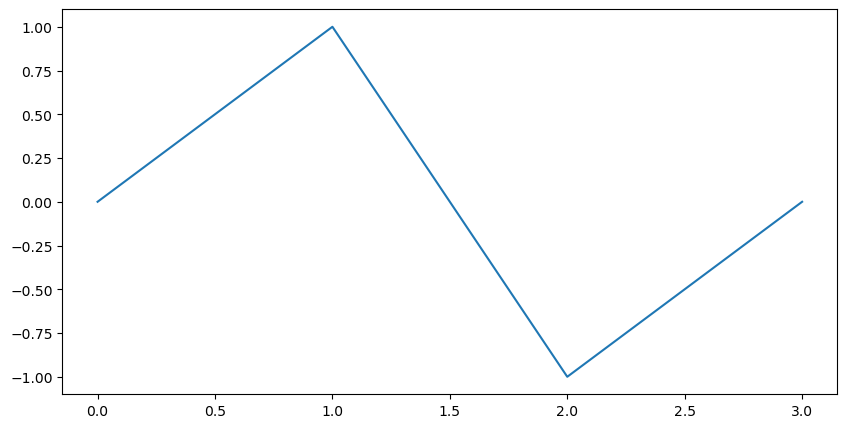

In [ ]:
peak_sig = np.array([0, 1, -1, 0])
# peak_sig = np.array([0, 1, 0, -1, 0])
print(len(peak_sig))

plt.figure(figsize=(10, 5))
plt.plot(range(len(peak_sig)), peak_sig);

In [ ]:
np.argmin(toy_sig)

18

length sig:  128


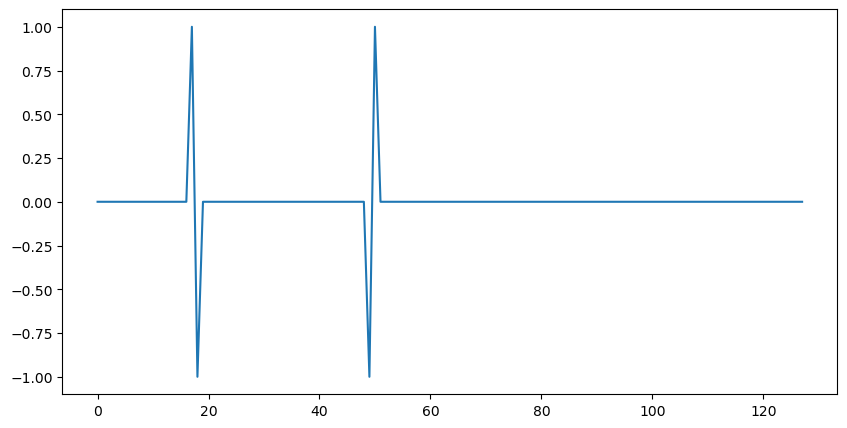

In [ ]:
n, n1, n2 = 128, 16, 28

toy_sig = np.r_[np.zeros(n1), peak_sig, np.zeros(n2), -peak_sig, np.zeros(n-n1-n2-2*len(peak_sig))]
print('length sig: ', len(toy_sig))
plt.figure(figsize=(10, 5))
plt.plot(range(len(toy_sig)), toy_sig);

In [ ]:
wavelet_type = 'db2'
print(pywt.Wavelet(wavelet_type))
max_level = pywt.dwt_max_level(data_len=len(toy_sig), 
                               filter_len=pywt.Wavelet(wavelet_type).dec_len)
max_level

Wavelet db2
  Family name:    Daubechies
  Short name:     db
  Filters length: 4
  Orthogonal:     True
  Biorthogonal:   True
  Symmetry:       asymmetric
  DWT:            True
  CWT:            False


5

In [ ]:
?pywt.wavedec

Signature: pywt.wavedec(data, wavelet, mode='symmetric', level=None, axis=-1)
Docstring:
Multilevel 1D Discrete Wavelet Transform of data.

Parameters
----------
data: array_like
    Input data
wavelet : Wavelet object or name string
    Wavelet to use
mode : str, optional
    Signal extension mode, see :ref:`Modes <ref-modes>`.
level : int, optional
    Decomposition level (must be >= 0). If level is None (default) then it
    will be calculated using the ``dwt_max_level`` function.
axis: int, optional
    Axis over which to compute the DWT. If not given, the
    last axis is used.

Returns
-------
[cA_n, cD_n, cD_n-1, ..., cD2, cD1] : list
    Ordered list of coefficients arrays
    where ``n`` denotes the level of decomposition. The first element
    (``cA_n``) of the result is approximation coefficients array and the
    following elements (``cD_n`` - ``cD_1``) are details coefficients
    arrays.

Examples
--------
>>> from pywt import wavedec
>>> coeffs = wavedec([1,2,3,4,5,6,7,8

In [ ]:
#['zero', 'constant', 'symmetric', 'periodic', 'smooth', 'periodization', 'reflect', 'antisymmetric', 'antireflect']
coeffs = pywt.wavedec(toy_sig, wavelet_type, mode='zero')

In [ ]:
for i, level in enumerate(coeffs):
    print(f'level: {i} | # coeffs: {len(level)} | max: {np.max(level):.3f} | argmax: {np.argmax(level)} | argmin: {np.argmin(level)}')     

level: 0 | # coeffs: 6 | max: 0.005 | argmax: 0 | argmin: 1
level: 1 | # coeffs: 6 | max: 0.094 | argmax: 1 | argmin: 2
level: 2 | # coeffs: 10 | max: 0.159 | argmax: 3 | argmin: 1
level: 3 | # coeffs: 18 | max: 0.258 | argmax: 7 | argmin: 3
level: 4 | # coeffs: 34 | max: 0.525 | argmax: 13 | argmin: 5
level: 5 | # coeffs: 65 | max: 1.061 | argmax: 25 | argmin: 9


In [ ]:
cA, cD = pywt.dwt(toy_sig, 'db2', mode='symmetric')

In [ ]:
cA

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        , -0.12940952,  0.61237244,
       -0.48296291,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.12940952,
       -0.61237244,  0.48296291,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ])

[<matplotlib.lines.Line2D>]

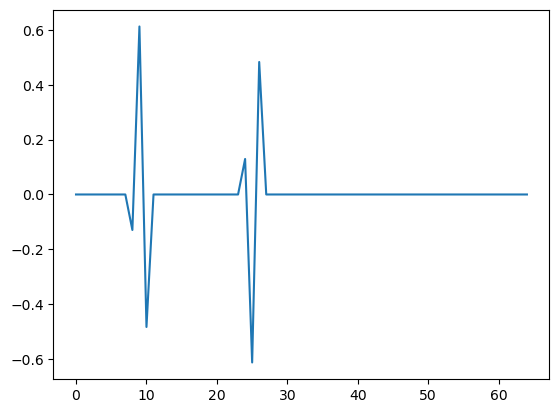

In [ ]:
plt.plot(range(len(cA)), cA)

[<matplotlib.lines.Line2D>]

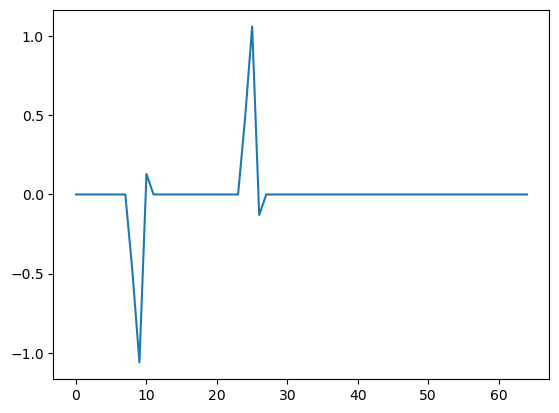

In [ ]:
plt.plot(range(len(cD)), cD)

In [ ]:
cD

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        , -0.48296291, -1.06066017,
        0.12940952,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.48296291,
        1.06066017, -0.12940952,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ])

In [ ]:
2**9

512

In [ ]:
import pywt

# Choose a wavelet
wavelet_name = 'db2'  # For example, Daubechies 2
wavelet = pywt.Wavelet(wavelet_name)

# Get the lengths of the decomposition and reconstruction filters
dec_len = wavelet.dec_len
rec_len = wavelet.rec_len

# Print the filter lengths
print(f"Decomposition filter length of {wavelet_name}: {dec_len}")
print(f"Reconstruction filter length of {wavelet_name}: {rec_len}")

# The support length of the wavelet can be considered as the maximum of these two lengths
support_length = max(dec_len, rec_len)
print(f"Support length of {wavelet_name} wavelet: {support_length}")


Decomposition filter length of db2: 4
Reconstruction filter length of db2: 4
Support length of db2 wavelet: 4


In [ ]:
128 // 4

32

In [ ]:
128, 64, 32, 16, 8, 4, 2

In [ ]:
N = 2

2**N - 1

3

In [ ]:
level = 6

wavelet = pywt.Wavelet(wavelet_name)
_, _, support = wavelet.wavefun(level=1)

128 // 2**(level-1)

4

In [ ]:
128//31

4

In [ ]:
len(support)

31

In [ ]:
#2**6
8

64

In [ ]:
# 0 0 0 0 0 ... 0 1 0 -1 ... 0 0 0 0 0 ...

In [ ]:
# 0, 4, 8, 12, 16
coeffs[6]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
coeffs[7]

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  1.41421356,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        , -1.41421356,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ])

In [ ]:
# db1 has four points

In [ ]:
128 / 32

4.0

In [ ]:
print(psi)
print(x)
x

[ 0.  1. -1.  0.]
[0.  0.5 1.  1.5]


array([0. , 0.5, 1. , 1.5])

In [ ]:
?pywt.Wavelet

Init signature: pywt.Wavelet(self, /, *args, **kwargs)
Docstring:     
Wavelet(name, filter_bank=None) object describe properties of
a wavelet identified by name.

In order to use a built-in wavelet the parameter name must be
a valid name from the wavelist() list.
To create a custom wavelet object, filter_bank parameter must
be specified. It can be either a list of four filters or an object
that a `filter_bank` attribute which returns a list of four
filters - just like the Wavelet instance itself.
File:           ~/mambaforge/envs/lssm/lib/python3.11/site-packages/pywt/_extensions/_pywt.cpython-311-darwin.so
Type:           type
Subclasses:     

In [ ]:
# pywt.wavelist()

In [ ]:
x

array([0.        , 0.00390625, 0.0078125 , 0.01171875, 0.015625  ,
       0.01953125, 0.0234375 , 0.02734375, 0.03125   , 0.03515625,
       0.0390625 , 0.04296875, 0.046875  , 0.05078125, 0.0546875 ,
       0.05859375, 0.0625    , 0.06640625, 0.0703125 , 0.07421875,
       0.078125  , 0.08203125, 0.0859375 , 0.08984375, 0.09375   ,
       0.09765625, 0.1015625 , 0.10546875, 0.109375  , 0.11328125,
       0.1171875 , 0.12109375, 0.125     , 0.12890625, 0.1328125 ,
       0.13671875, 0.140625  , 0.14453125, 0.1484375 , 0.15234375,
       0.15625   , 0.16015625, 0.1640625 , 0.16796875, 0.171875  ,
       0.17578125, 0.1796875 , 0.18359375, 0.1875    , 0.19140625,
       0.1953125 , 0.19921875, 0.203125  , 0.20703125, 0.2109375 ,
       0.21484375, 0.21875   , 0.22265625, 0.2265625 , 0.23046875,
       0.234375  , 0.23828125, 0.2421875 , 0.24609375, 0.25      ,
       0.25390625, 0.2578125 , 0.26171875, 0.265625  , 0.26953125,
       0.2734375 , 0.27734375, 0.28125   , 0.28515625, 0.28906

In [ ]:
len(x)

258

In [ ]:
psi

array([ 0.,  1., -1.,  0.])

In [ ]:
x

array([0. , 0.5, 1. , 1.5])

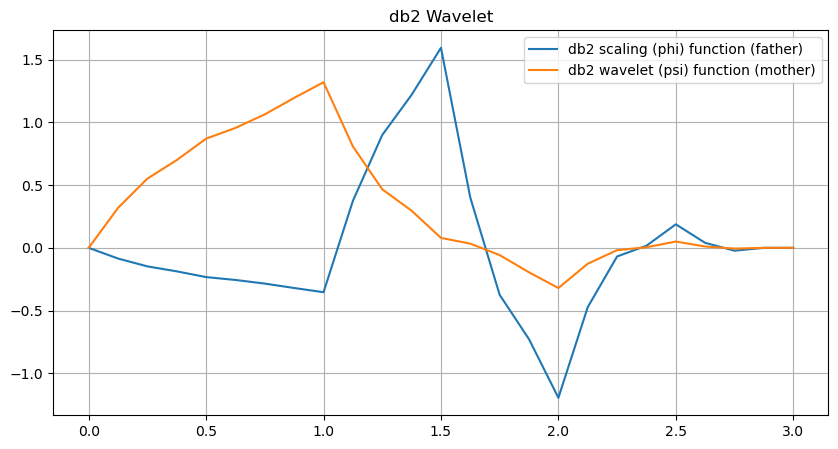

In [ ]:
import matplotlib.pyplot as plt

wavelet_name = 'db2'
# Create the Daubechies 1 wavelet (db1)
wavelet = pywt.Wavelet(wavelet_name)

# Get the wavelet function values on the built-in support interval
#level=1
# phi: father (scaling fun), and psi: mother (wavelet fun)
phi, psi, x = wavelet.wavefun(level=3)

# Plot the wavelet function
plt.figure(figsize=(10, 5))
plt.plot(x, psi, label=f'{wavelet_name} scaling (phi) function (father)')
plt.plot(x, phi, label=f'{wavelet_name} wavelet (psi) function (mother)')
plt.title(f'{wavelet_name} Wavelet')

plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# asymmetric least squares smoothing
# import numpy as np
# from scipy.sparse import diags
# from scipy.sparse.linalg import spsolve

# def baseline_als(y, lam, p, niter=10):
#     L = len(y)
#     D = diags([1,-2,1], [0,-1,-2], shape=(L,L-2))
#     w = np.ones(L)
#     for i in range(niter):
#         W = diags([w], [0], shape=(L,L))
#         Z = W + lam * D.dot(D.transpose())
#         z = spsolve(Z, w*y)
#         w = p * (y > z) + (1-p) * (y < z)
#     return z

# # Parameters for baseline fitting
# lam = 1e5  # Smoothness parameter
# p = 0.01   # Asymmetry parameter

# # Assuming 'spectrum' is your 1D numpy array containing the spectral data
# baseline = baseline_als(spectrum, lam, p)

# # Subtract the baseline from the original spectrum
# corrected_spectrum = spectrum - baseline

# # Plot the results
# plt.figure(figsize=(10, 6))
# plt.plot(spectrum, label='Original Spectrum')
# plt.plot(corrected_spectrum, label='Corrected Spectrum', color='red')
# plt.plot(baseline, label='Estimated Baseline', linestyle='--')
# plt.legend()
# plt.show()


## DWT from scratch

In [ ]:
# How to know the time support of a wavelet?    
import pywt
wavelet = pywt.Wavelet('db2')
phi, psi, x = wavelet.wavefun(level=1)

In [ ]:
psi

array([ 0.       , -0.1830127, -0.3169873,  1.1830127, -0.6830127,
        0.       ,  0.       ])

In [ ]:
wavelet.dec_len

4

In [ ]:
# from math import floor, log2

# data = np.array([1,2,3,4,5,6,7,8,9])
# print(list(data))
# floor((len(data) + wavelet.dec_len - 1) / 2)

In [ ]:
w = pywt.Wavelet('haar')
pywt.dwt_max_level(data_len=len(data), filter_len=w.dec_len)

3

In [ ]:
def max_level(data, filter_len): return floor(log2(len(data)/(filter_len - 1)))
max_level(data, w.dec_len)

3

In [ ]:
data

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
coeffs = pywt.wavedec(data, 'haar', level=None, axis=-1)

In [ ]:
coeffs

[array([12.72792206, 25.45584412]),
 array([-5.65685425e+00,  6.96572797e-17]),
 array([-2.00000000e+00, -2.00000000e+00, -7.48835434e-17]),
 array([-7.07106781e-01, -7.07106781e-01, -7.07106781e-01, -7.07106781e-01,
        -3.33066907e-16])]

In [ ]:
data = np.array(range(1,10))
print('data: ', data)

kernel = np.repeat([1, -1], 1)
print('kernel: ', kernel)

data:  [1 2 3 4 5 6 7 8 9]
kernel:  [ 1 -1]


In [ ]:
def norm(w): return np.array(w) / np.sqrt(np.sum(np.square(w)))

norm(np.array([1, 1, 1, 1, -1, -1, -1, -1]))

array([ 0.35355339,  0.35355339,  0.35355339,  0.35355339, -0.35355339,
       -0.35355339, -0.35355339, -0.35355339])

In [ ]:
def pad_right(arr, kernel):  return np.r_[arr, np.full(len(kernel) - 1, arr[-1])]

pad_right(data, kernel)

array([1, 2, 3, 4, 5, 6, 7, 8, 9, 9])

In [ ]:
def conv_i(arr, kernel): return np.sum(arr * norm(kernel))

conv_i(data[:2], kernel)

-0.7071067811865475

In [ ]:
def conv(arr, kernel):
    result = []
    arr_pad = pad_right(arr, kernel)
    chunk_size = len(kernel)
    for i in range(len(arr_pad) - chunk_size +1):
        result.append(np.sum(arr_i*norm(kernel)))
    return np.r_[result]

data = np.array([1,2,3,4,5,6,7,8,9])
kernel = np.repeat([1, -1], 1)
conv(data, kernel)

array([-0.70710678, -0.70710678, -0.70710678, -0.70710678, -0.70710678,
       -0.70710678, -0.70710678, -0.70710678,  0.        ])

In [ ]:
def subsample(arr, modulo=2): return np.array([d for i,d in enumerate(arr) if not i % modulo])

phi = np.repeat([1, 1], 1)
approx_1 = subsample(conv(data, phi)); approx_1

array([ 2.12132034,  4.94974747,  7.77817459, 10.60660172, 12.72792206])

In [ ]:
psi = np.repeat([1, -1], 1)
detail_1 = subsample(conv(data, psi)); detail_1

array([-0.70710678, -0.70710678, -0.70710678, -0.70710678,  0.        ])

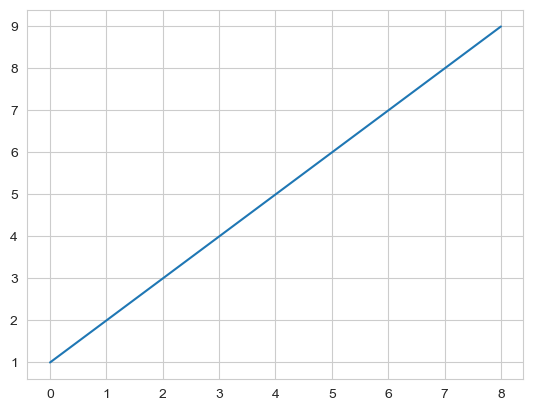

In [ ]:
plt.plot(data);

In [ ]:
coeffs

[array([12.72792206, 25.45584412]),
 array([-5.65685425e+00,  6.96572797e-17]),
 array([-2.00000000e+00, -2.00000000e+00, -7.48835434e-17]),
 array([-7.07106781e-01, -7.07106781e-01, -7.07106781e-01, -7.07106781e-01,
        -3.33066907e-16])]

In [ ]:
detail_2 = subsample(conv(approx_1, psi)); detail_2

array([-2., -2.,  0.])

In [ ]:
approx_2 = subsample(conv(approx_1, phi)); approx_2

array([ 5., 13., 18.])

In [ ]:
detail_3 = subsample(conv(approx_2, psi)); detail_3

array([-5.65685425,  0.        ])

In [ ]:
approx_3 = subsample(conv(approx_2, phi)); approx_3

array([12.72792206, 25.45584412])

In [ ]:
peak  = np.repeat([1, -1], 1); peak

array([ 1, -1])

In [ ]:
data = np.zeros(24)



In [ ]:
data[6:8] = np.repeat([1, -1], 1)
data[12:16] = np.repeat([1, -1], 2)

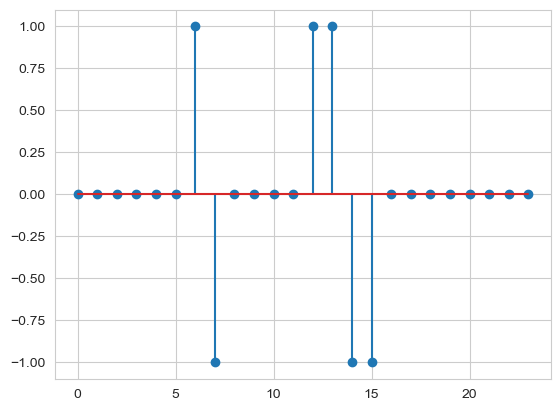

In [ ]:
plt.stem(data);

In [ ]:
w = pywt.Wavelet('haar')
max_level = pywt.dwt_max_level(data_len=len(data), filter_len=w.dec_len); max_level

4

In [ ]:
coeffs = pywt.wavedec(data, 'haar', level=None, axis=-1); coeffs

[array([-4.26642159e-17,  0.00000000e+00]),
 array([4.26642159e-17, 0.00000000e+00]),
 array([0.00000000e+00, 6.03363127e-17, 0.00000000e+00]),
 array([0., 0., 0., 2., 0., 0.]),
 array([0.        , 0.        , 0.        , 1.41421356, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ])]

In [ ]:
len(coeffs)

5

In [ ]:
# i*4
# i*2

12

In [ ]:
names_mean

array(['LUI-0', 'LUI-1', 'LUI-2', 'LUI-3', 'SPA1-0', 'SPA1-1', 'SPA1-2',
       'SPA1-3', 'TM4.1-0', 'TM4.1-1', 'TM4.1-2', 'TM4.1-3'], dtype='<U7')

In [ ]:
X_mean[0]

array([ 0.05416663,  0.05375457,  0.05353549, ..., -0.07271787,
       -0.07291171, -0.07306585])

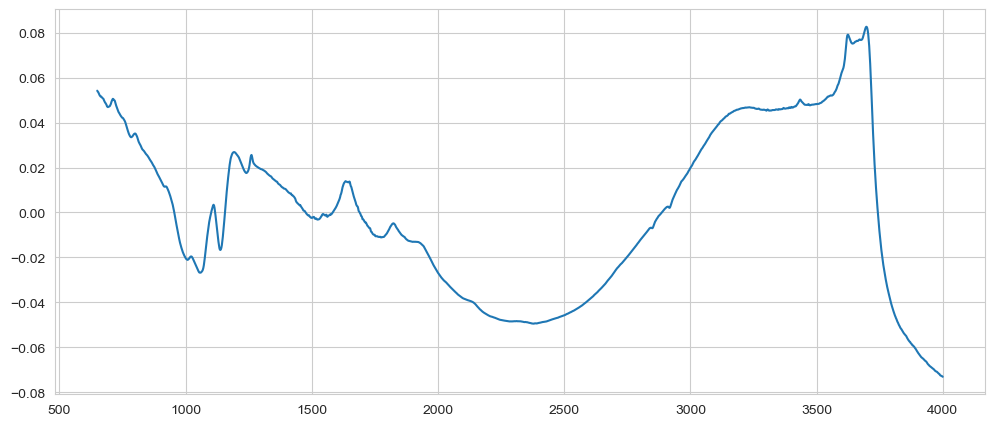

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(wavenumbers, X_mean[0]);

## Diffs wavelet coeffs

In [ ]:
def resample_coeffs(coeffs, signal, verbose=True):
    ratio_signal_coeffs = len(signal)/len(coeffs)
    if verbose: print(f'support in wns: {2*ratio_signal_coeffs}')
    coeffs_resampled = np.zeros_like(signal)
    for i, coeff in enumerate(coeffs): 
        coeffs_resampled[int(i*ratio_signal_coeffs)] = coeff
    return coeffs_resampled

In [ ]:
wavenumbers[:10]

array([11536, 11528, 11520, 11512, 11504, 11496, 11488, 11480, 11472,
       11464])

In [ ]:
[(i, name) for i, name in enumerate(names_mean)]

[(0, 'LUI-0'),
 (1, 'LUI-1'),
 (2, 'LUI-2'),
 (3, 'LUI-3'),
 (4, 'SPA1-0'),
 (5, 'SPA1-1'),
 (6, 'SPA1-2'),
 (7, 'SPA1-3'),
 (8, 'TM4.1-0'),
 (9, 'TM4.1-1'),
 (10, 'TM4.1-2'),
 (11, 'TM4.1-3')]

In [ ]:
w = pywt.Wavelet('haar')
max_level = pywt.dwt_max_level(data_len=len(X_mean[0]), filter_len=w.dec_len); max_level

9

In [ ]:
idx_low, idx_high = 0, 4
signal = X_mean[idx_high] - X_mean[idx_low]
coeffs_all = pywt.wavedec(signal, 'haar', level=None, axis=-1)

for i, coeffs in enumerate(coeffs_all):
    print(f'level: {i} | coeffs length: {len(coeffs)} | ratio signal_length/coeff_length: {len(X_mean[0])/len(coeffs):.2f}')

level: 0 | coeffs length: 2 | ratio signal_length/coeff_length: 474.50
level: 1 | coeffs length: 2 | ratio signal_length/coeff_length: 474.50
level: 2 | coeffs length: 4 | ratio signal_length/coeff_length: 237.25
level: 3 | coeffs length: 8 | ratio signal_length/coeff_length: 118.62
level: 4 | coeffs length: 15 | ratio signal_length/coeff_length: 63.27
level: 5 | coeffs length: 30 | ratio signal_length/coeff_length: 31.63
level: 6 | coeffs length: 60 | ratio signal_length/coeff_length: 15.82
level: 7 | coeffs length: 119 | ratio signal_length/coeff_length: 7.97
level: 8 | coeffs length: 238 | ratio signal_length/coeff_length: 3.99
level: 9 | coeffs length: 475 | ratio signal_length/coeff_length: 2.00


In [ ]:
# Define the wavelet and decomposition level
wavelet = 'db4'
level = 2

# Perform DWT on the signal
coeffs = pywt.wavedec(X_mean[idx_high], wavelet, level=level)

# Set the high frequency coefficients to zero
coeffs[1:] = [np.zeros_like(c) for c in coeffs[1:]]

# Perform inverse DWT to obtain the filtered signal
filtered_signal = pywt.waverec(coeffs, wavelet)

In [ ]:
len(filtered_signal)

950

In [ ]:
len(X_mean[idx_high])

949

<Figure size 640x480 with 0 Axes>

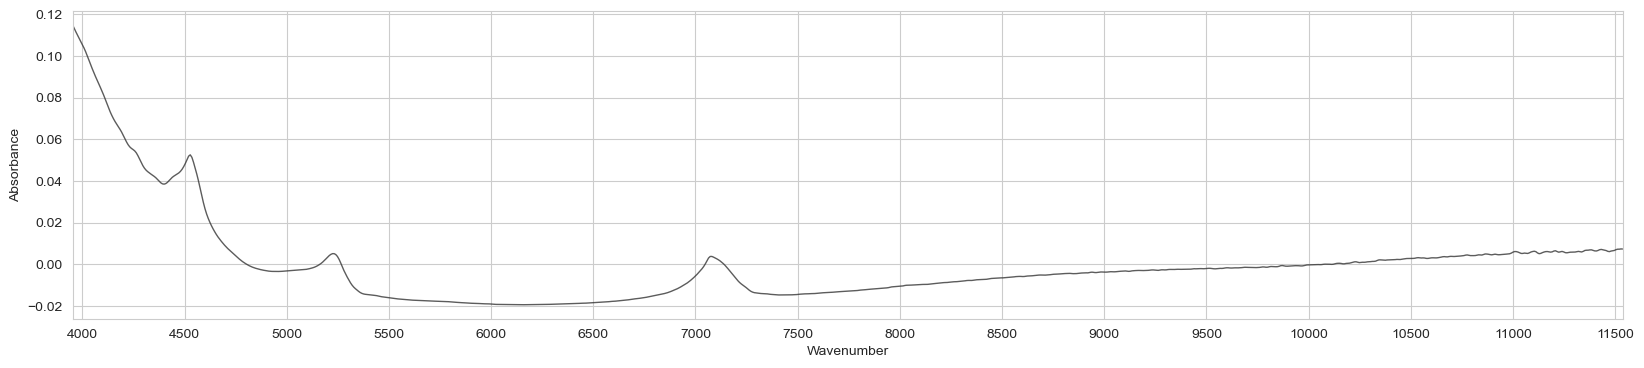

In [ ]:
plot_spectra(X_mean[idx_high], wavenumbers, ascending=ascending)

<Figure size 640x480 with 0 Axes>

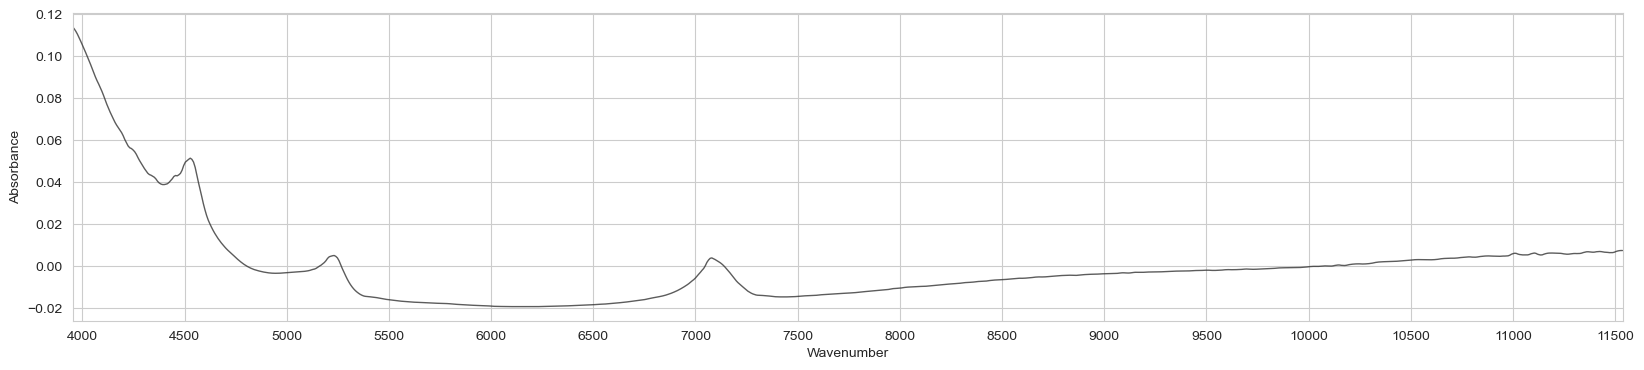

In [ ]:
plot_spectra(filtered_signal[:len(X_mean[idx_high])], wavenumbers, ascending=ascending)

In [ ]:
window_size = 21

# Create a moving average filter kernel
kernel = np.ones(window_size) / window_size

# Apply the moving average filter to the signal using convolution
rolling_avg = np.convolve(X_mean[idx_high], kernel, mode='same')

<Figure size 640x480 with 0 Axes>

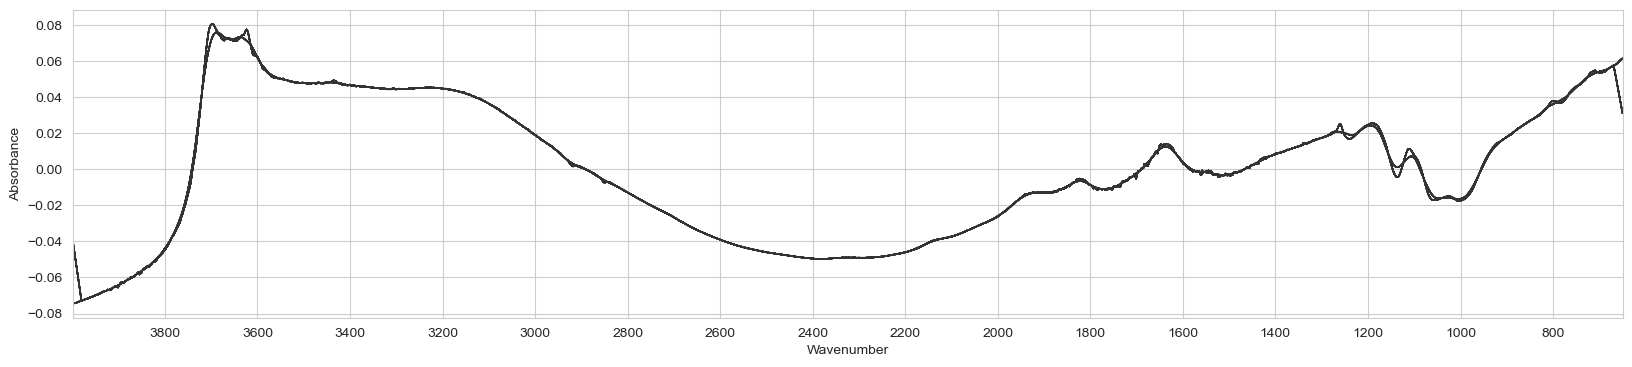

In [ ]:
plot_spectra(np.c_[X_mean[idx_high], rolling_avg].transpose(), wavenumbers, ascending=ascending)

<Figure size 640x480 with 0 Axes>

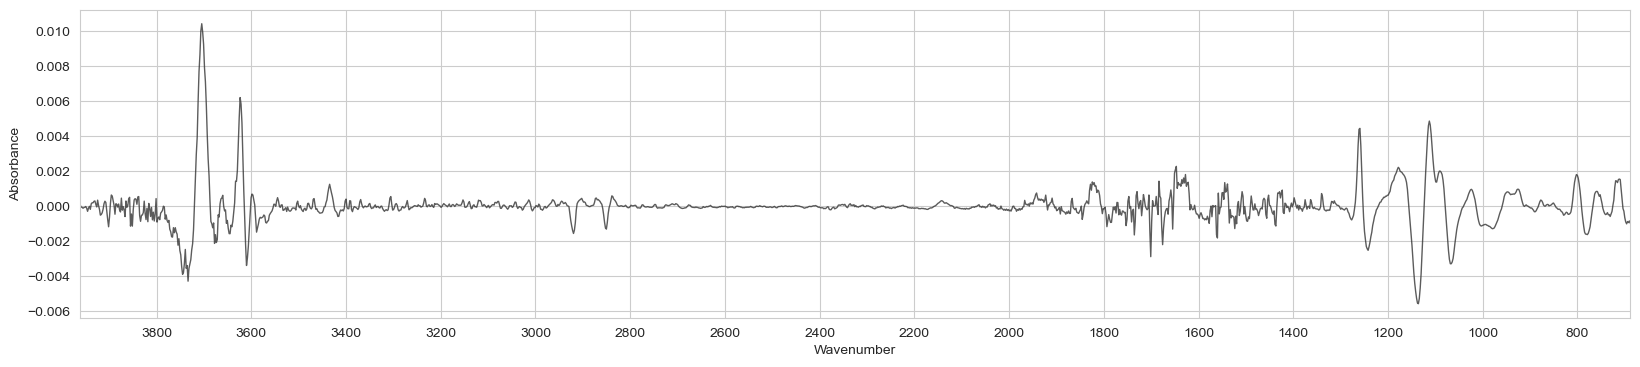

In [ ]:
pad = 20
plot_spectra(X_mean[idx_high][pad:-pad] - rolling_avg[pad:-pad], wavenumbers[pad:-pad], ascending=ascending)

In [ ]:
p_fitted = np.polynomial.Polynomial.fit(range(len(X_mean[idx_high])), X_mean[idx_high], deg=3) 
print(p_fitted)
trend = [p_fitted(i) for i in range(len(X_mean[idx_high]))]

-0.01378006 + 0.06715092·x + 0.04129263·x² - 0.11557754·x³


<Figure size 640x480 with 0 Axes>

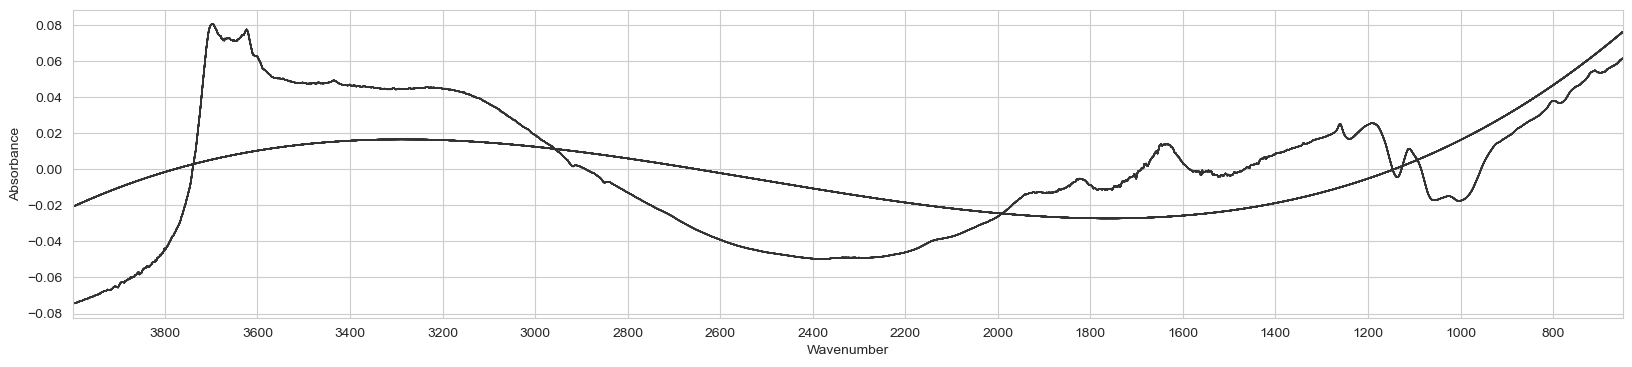

In [ ]:
plot_spectra(np.c_[X_mean[idx_high], trend].transpose(), wavenumbers, ascending=ascending)v

<Figure size 640x480 with 0 Axes>

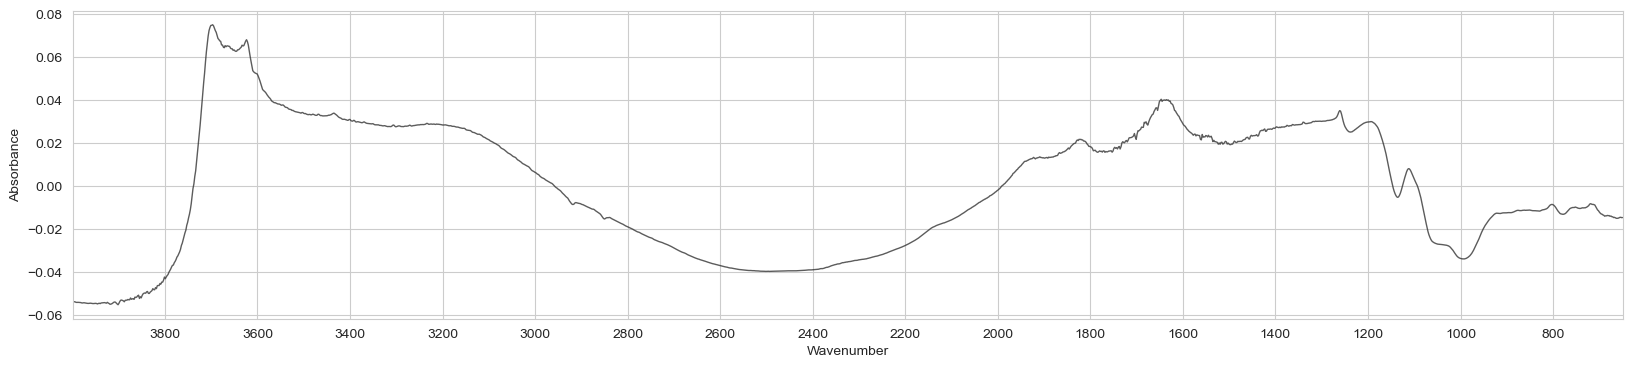

In [ ]:
plot_spectra(X_mean[idx_high] - trend, wavenumbers, ascending=ascending)

<Figure size 640x480 with 0 Axes>

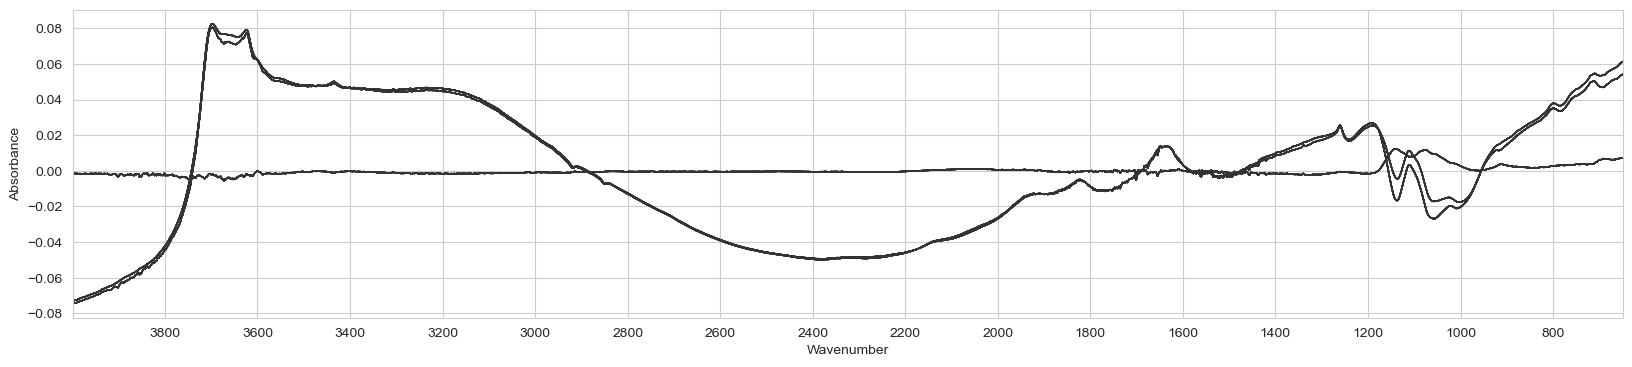

In [ ]:
plot_spectra(np.c_[X_mean[idx_high], X_mean[idx_low], signal].transpose(), wavenumbers, ascending=ascending)a

In [ ]:
p_fitted = np.polynomial.Polynomial.fit(range(len(signal)), signal, deg=6) 
print(p_fitted)
trend = [p_fitted(i) for i in range(len(signal))]

-0.00013277 + 0.00129567·x - 0.00524053·x² - 0.01199011·x³ +
0.01700581·x⁴ + 0.00733829·x⁵ - 0.01065477·x⁶


<Figure size 640x480 with 0 Axes>

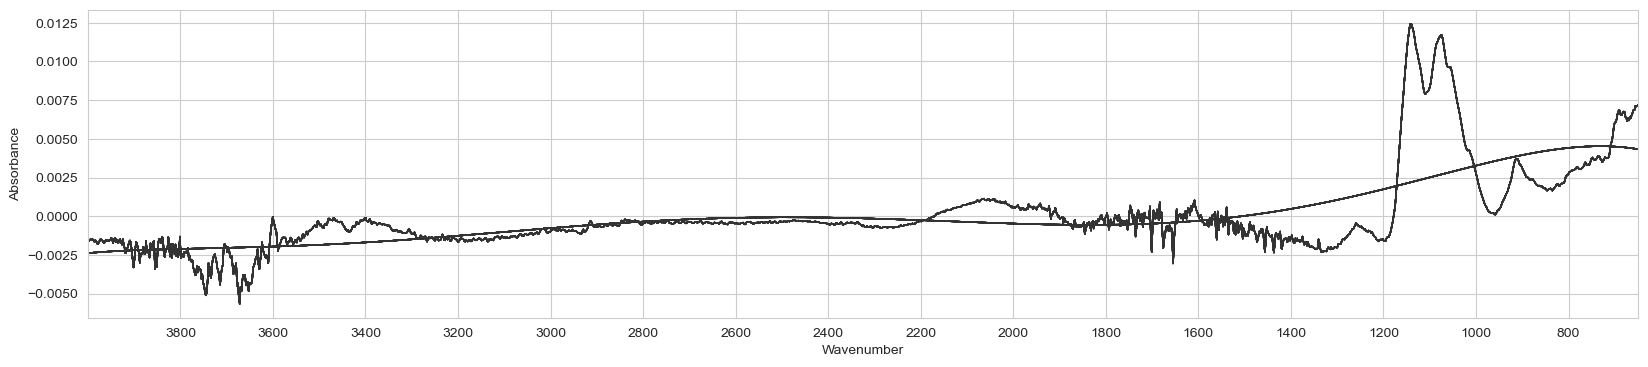

In [ ]:
plot_spectra(np.c_[signal, trend].transpose(), wavenumbers, ascending=ascending)

<Figure size 640x480 with 0 Axes>

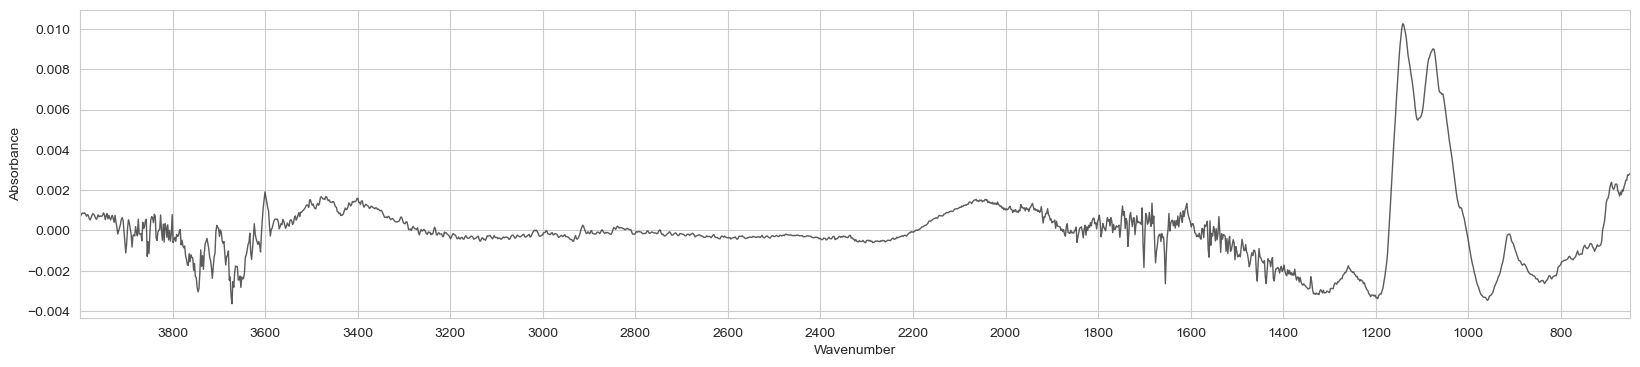

In [ ]:
plot_spectra(signal - trend, wavenumbers, ascending=ascending)

support in wns: 248.28571428571428


<Figure size 640x480 with 0 Axes>

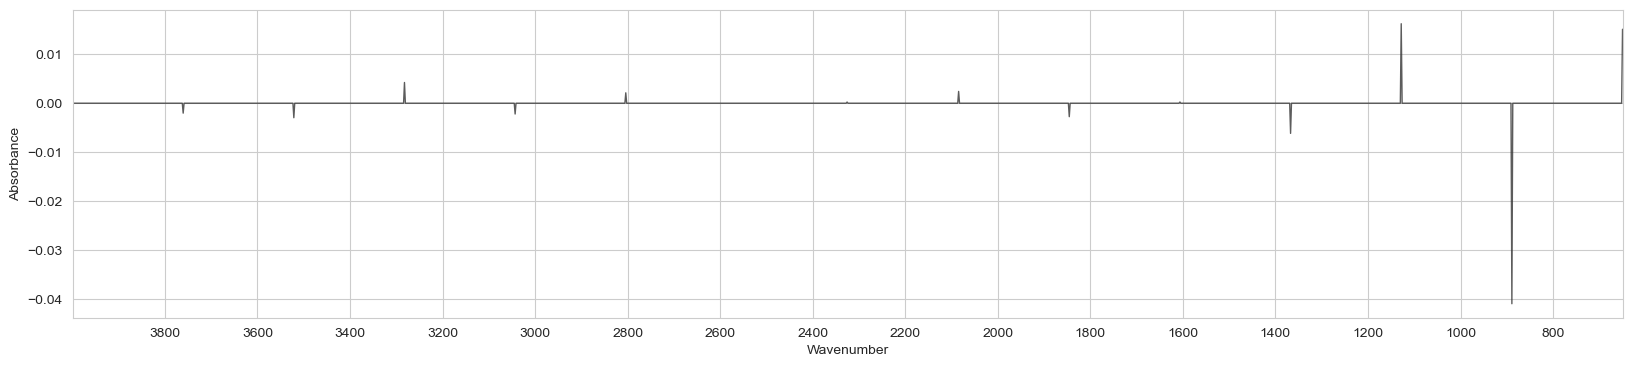

In [ ]:
coeffs_resampled = resample_coeffs(coeffs_all[4], X_mean[0])
plot_spectra(coeffs_resampled, wavenumbers, ascending=ascending)

Polynomial([ 0.00609622,  0.00763388, -0.02922503,  0.00697922,  0.01824135], domain=[   0., 1737.], window=[-1.,  1.], symbol='x')

In [ ]:
def get_coeffs(X, start=0, stop=3):
    coeffs = [pywt.wavedec(X_mean[4], 'haar', level=None, axis=-1) for i in [0, 1, 2]]
# coeffs_1 = pywt.wavedec(X_mean[5], 'db3', level=None, axis=-1)

In [ ]:
from sklearn.decomposition import PCA, KernelPCA

In [ ]:
idx_start = 8
diffs = X_mean[idx_start:idx_start+4][0, :] - X_mean[idx_start:idx_start+4][1:, :]

In [ ]:
diffs

array([[ 0.02144774,  0.02148407,  0.02153625, ..., -0.0064682 ,
        -0.00647894, -0.0064958 ],
       [-0.00336363, -0.00344735, -0.0035209 , ..., -0.00063461,
        -0.00070871, -0.00076759],
       [ 0.0015205 ,  0.00177627,  0.00148509, ...,  0.00197625,
         0.00186911,  0.001724  ]])

In [ ]:
n_components = 3
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(diffs)

In [ ]:
X_pca

array([[-2.44661780e-01, -1.16368862e-01,  8.22627629e-17],
       [ 2.70994399e-01, -8.54504109e-02,  8.22627629e-17],
       [-2.63326193e-02,  2.01819273e-01,  8.22627629e-17]])

In [ ]:
pca.explained_variance_ratio_

array([6.85146007e-01, 3.14853993e-01, 1.03809267e-31])

<matplotlib.collections.PathCollection>

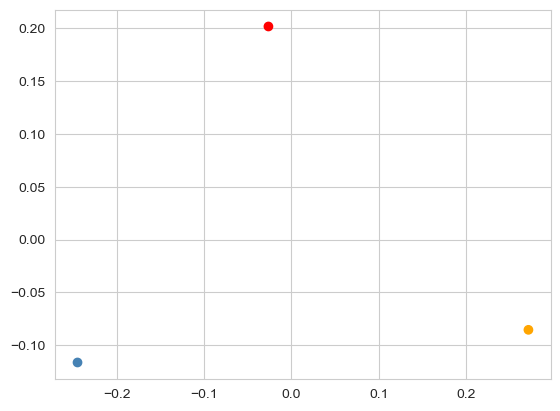

In [ ]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=['steelblue', 'orange', 'red'])

<Figure size 640x480 with 0 Axes>

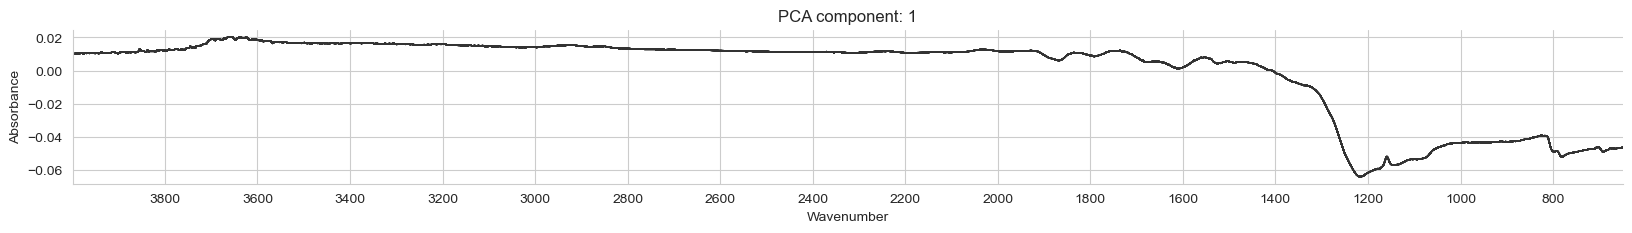

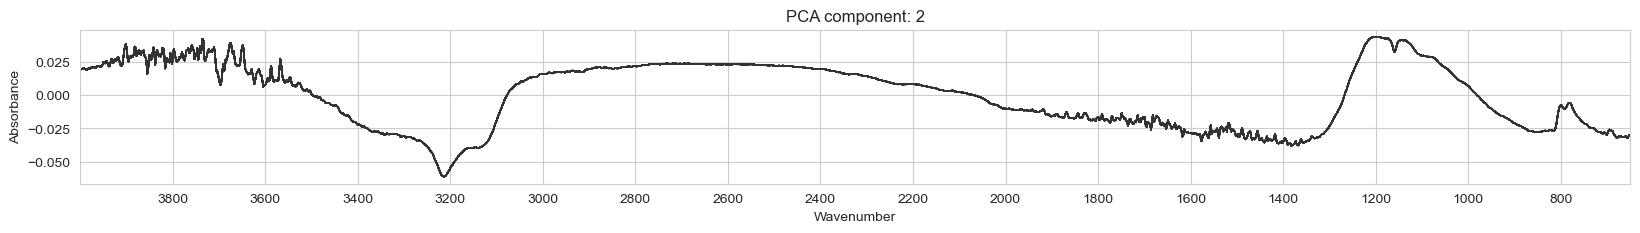

In [ ]:
for i in range(2):
    plot_spectra(pca.components_[i,:][None,:], wavenumbers, 
                 alpha=0.8, color='#333', 
                 title=f'PCA component: {i+ 1}',
                 ascending=ascending,
                 figsize=(20, 2))

[None, None, None]

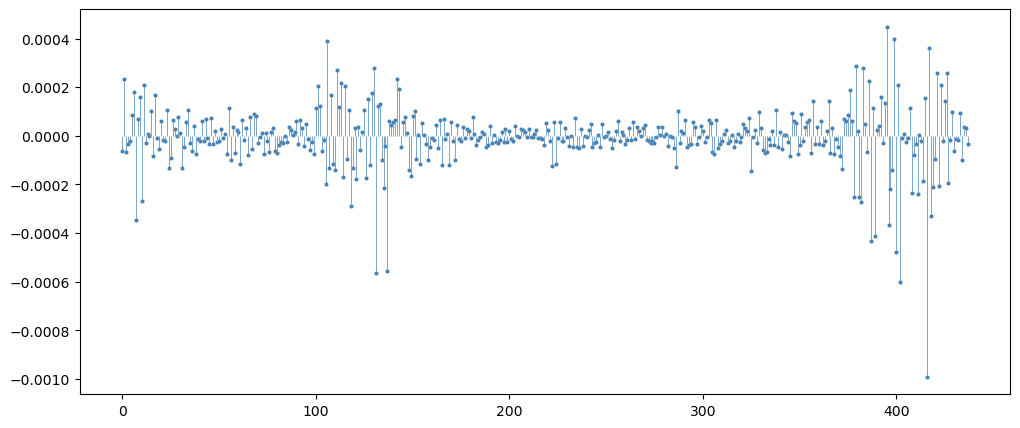

In [ ]:
coeffs_0 = pywt.wavedec(X_mean[4], 'db3', level=None, axis=-1)
coeffs_1 = pywt.wavedec(X_mean[5], 'db3', level=None, axis=-1)
coeffs = [d2-d1 for d1, d2 in zip(coeffs_0, coeffs_1)]

plt.figure(figsize=(12,5))
markerLines, stemLines, baseLines = plt.stem(coeffs[7])
plt.setp(markerLines, color = 'steelblue', markersize = 3,
            markeredgecolor = 'white', markeredgewidth = 0.1)
plt.setp(stemLines, color = 'steelblue', linewidth = 0.5, linestyle = '-')
plt.setp(baseLines, color = 'white', linewidth = 0.1, linestyle  = '--')
# plt.margins(0.1, 0.1)
# plt.yscale('log')
# plt.ylim(1e-4, 1e0)

(0.0001, 1.0)

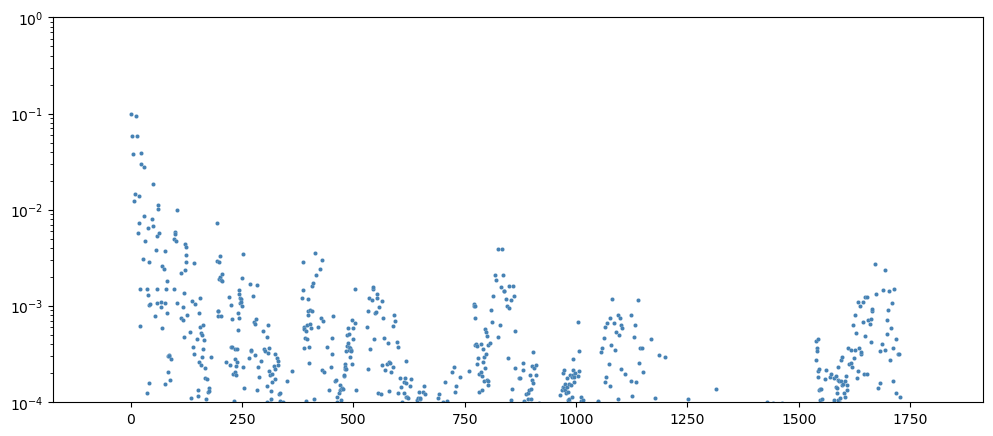

In [ ]:
plt.figure(figsize=(12,5))
markerLines, stemLines, baseLines = plt.stem(np.concatenate(coeffs[1:]))
plt.setp(markerLines, color = 'steelblue', markersize = 3,
            markeredgecolor = 'white', markeredgewidth = 0.1)
plt.setp(stemLines, color = 'steelblue', linewidth = 0, linestyle = '-')
plt.setp(baseLines, color = 'white', linewidth = 0.1, linestyle  = '--')
plt.margins(0.1, 0.1)
plt.yscale('log')
plt.ylim(1e-4, 1e0)

(0.0001, 1.0)

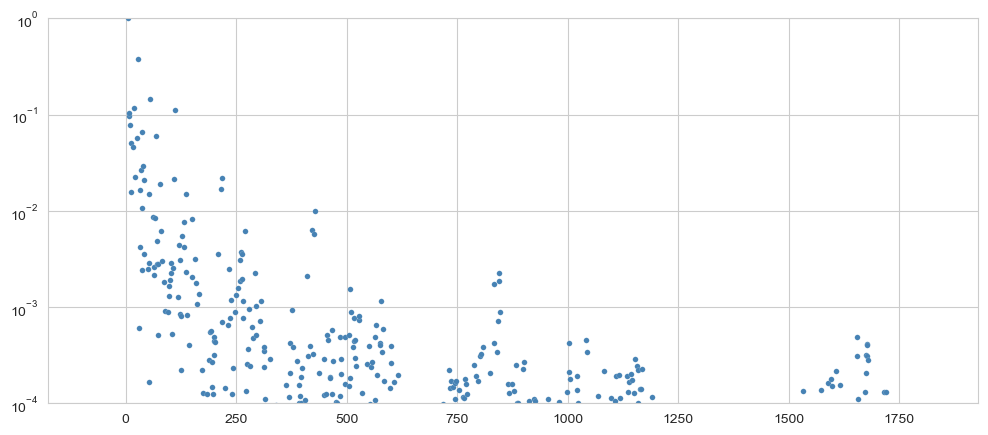

In [ ]:
plt.figure(figsize=(12,5))
markerLines, stemLines, baseLines = plt.stem(np.concatenate(coeffs[1:]))
plt.setp(markerLines, color = 'steelblue', markersize = 4,
            markeredgecolor = 'white', markeredgewidth = 0.1)
plt.setp(stemLines, color = 'steelblue', linewidth = 0, linestyle = '-')
plt.setp(baseLines, color = 'white', linewidth = 0.1, linestyle  = '--')
plt.margins(0.1, 0.1)
plt.yscale('log')
plt.ylim(1e-4, 1e0)

In [ ]:
len(coeffs[1:])

10

#### Retrieving coeffs location

In [ ]:
for coeff in coeffs[1:][::-1]:
    print(len(coeff), len(wavenumbers)/len(coeff))

NameError: name 'coeffs' is not defined

In [ ]:
wavenumbers[700]

1999.82

In [ ]:
np.repeat([1, -1], 1)

array([ 1, -1])

In [ ]:
support_size

2

In [ ]:
signal = X_mean[8].copy()
# support_size = 32
# amplitude = 0.01
# signal[700:(700 + support_size)] = signal[(700 + support_size)] + np.repeat([amplitude, -amplitude], support_size/2)

In [ ]:
np.repeat([amplitude, -amplitude], support_size/2)

array([ 0.01, -0.01])

In [ ]:
wavelet_name = 'sym4'
support_size = pywt.Wavelet(wavelet_name).dec_len
coeffs = pywt.wavedec(signal, wavelet_name, level=None, axis=-1)

[522, 1567, 87, 273, 265]
[46, 280, 1566, 93, 1550]
[45, 574, 317, 619, 1541]
[484, 712, 341, 569, 655]
[1329, 460, 562, 715, 357]
[347, 955, 521, 608, 1303]


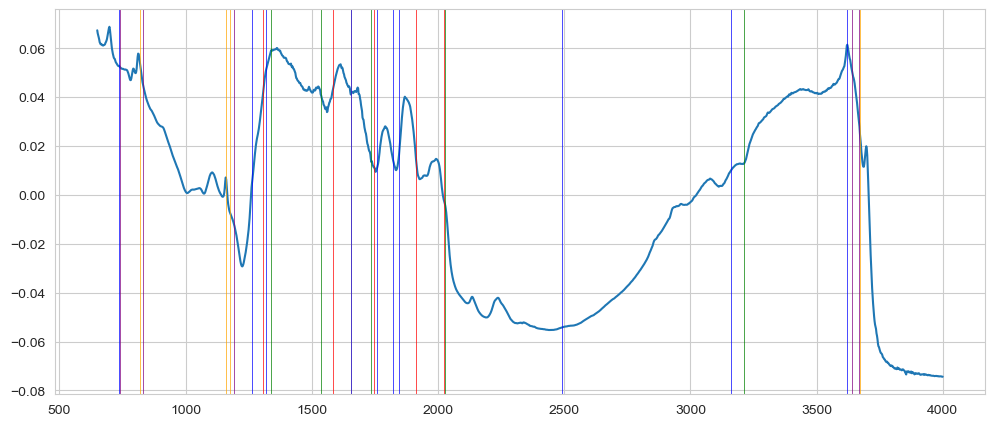

In [ ]:
level = 5
ntop = 5

plt.figure(figsize=(12,5))
plt.plot(wavenumbers, signal)
# for idx in get_wn_idx(coeffs[1:][::-1][level-1], support_size=support_size, ntop=1):
#     plt.axvline(x=idx, color='r', linestyle='-', lw=0.5)    

for idx in get_wn_idx(coeffs[1:][::-1][1], support_size=support_size, ntop=ntop):
    plt.axvline(x=idx, color='orange', linestyle='-', lw=0.5)    

for idx in get_wn_idx(coeffs[1:][::-1][2], support_size=support_size, ntop=ntop):
    plt.axvline(x=idx, color='purple', linestyle='-', lw=0.5)    
    
for idx in get_wn_idx(coeffs[1:][::-1][3], support_size=support_size, ntop=ntop):
    plt.axvline(x=idx, color='b', linestyle='-', lw=0.5)    

for idx in get_wn_idx(coeffs[1:][::-1][4], support_size=support_size, ntop=ntop):
    plt.axvline(x=idx, color='r', linestyle='-', lw=0.5)    
    
for idx in get_wn_idx(coeffs[1:][::-1][5], support_size=support_size, ntop=ntop):
    plt.axvline(x=idx, color='g', linestyle='-', lw=0.5)    

for idx in get_wn_idx(coeffs[1:][::-1][6], support_size=support_size, ntop=ntop):
    plt.axvline(x=idx, color='blue', linestyle='-', lw=0.5)    

In [ ]:
wavenumbers

array([ 649.8933,  651.8218,  653.7502, ..., 3995.784 , 3997.712 ,
       3999.641 ])

In [ ]:
coeffs[1:][::-1][0]

array([ 2.91370420e-04,  3.38322311e-04,  4.12978644e-04,  1.84682149e-04,
        1.84441733e-04,  1.26430692e-04,  1.78332330e-04,  2.75106964e-04,
        1.71020846e-04,  2.62605316e-04,  1.72109791e-04, -8.92085915e-05,
       -1.12571400e-04, -2.94792817e-04, -5.53127209e-04, -3.70340106e-04,
        4.66690476e-05,  1.00791001e-04,  5.42506465e-04,  4.00476997e-04,
        4.89996715e-04,  3.22497261e-04,  2.20079915e-04,  3.00251681e-04,
        2.31139065e-04,  1.79421275e-04,  6.63266161e-05,  2.40953707e-04,
        3.12258355e-04,  5.29849253e-04,  4.53651427e-04,  5.61711485e-04,
        4.22425591e-04,  2.94509974e-04,  1.63016397e-04, -1.01087985e-04,
       -1.90734983e-04, -2.25453926e-04, -8.72711189e-05,  1.12330983e-04,
        3.30855263e-04,  5.00914444e-04,  4.55574757e-04,  3.04904444e-04,
        2.97847518e-04,  3.75303995e-04,  2.33571512e-04,  1.49722790e-04,
        2.34052345e-04,  2.32638131e-04,  1.67174185e-04,  2.11679486e-04,
        2.12414877e-04,  

In [ ]:
def get_wn_idx(coeff, support_size, ntop=5):
    sorted_indices = np.argsort(coeff)
    idx_lower_bound = sorted_indices[-ntop:]
    upscaling = len(wavenumbers)/len(coeff)
    
    idx = []
    for i in idx_lower_bound:
        low_b = upscaling*i
        up_b = upscaling*(i+support_size)
        up_b = min(up_b, len(wavenumbers) - 1)
        # idx.append(int((low_b + up_b)/2))
        idx.append(int((low_b)))
        
    # idx = [int((upscaling*i + upscaling*(i+support_size))//2) for i in idx_lower_bound]
    print(idx)
    return wavenumbers[idx]

In [ ]:
get_wn_idx(coeffs[1:][::-1][level-1], support_size=support_size, ntop=20)

[1628, 434, 651, 1520, 977, 1683, 1086, 1194, 1303, 760, 217, 869, 325, 1412, 543, 1574]


array([3789.438, 1486.848, 1905.325, 3581.163, 2534.006, 3895.503,
       2744.208, 2952.483, 3162.686, 2115.528, 1068.371, 2325.731,
       1276.645, 3372.889, 1697.051, 3685.301])

In [ ]:
len(wavenumbers)

1738

In [ ]:
level1 = coeffs[1:][::-1][0]

sorted_indices = np.argsort(level1)
highest_indices = sorted_indices[-5:]; highest_indices

array([798, 797, 794, 795, 796])

In [ ]:
wavenumbers[2*799]

3731.584

In [ ]:
# 0, 8, 16, 24, 32, ... I guess
# 0, 4, 8, 12, 14, 
# 0, 2, 4, 6

# i wns = [12, 13, 14, 15, ...]

# take every 2, or every 4, 8, ... according to level
#2**(max_details - level)

In [ ]:
level = 2
index_peak = 3
level*index_peak

6

In [ ]:
len(data)

12

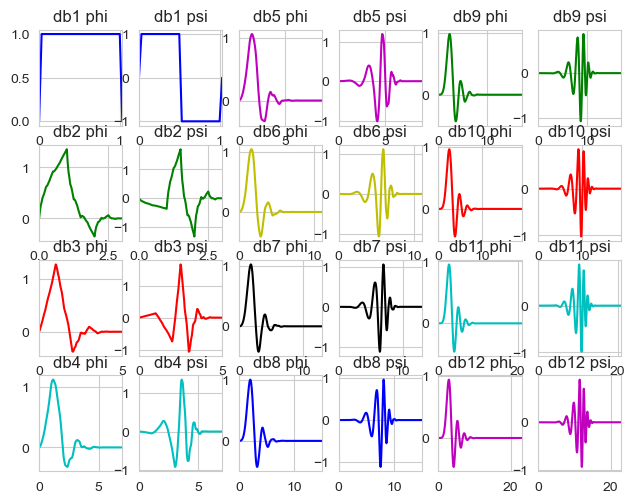

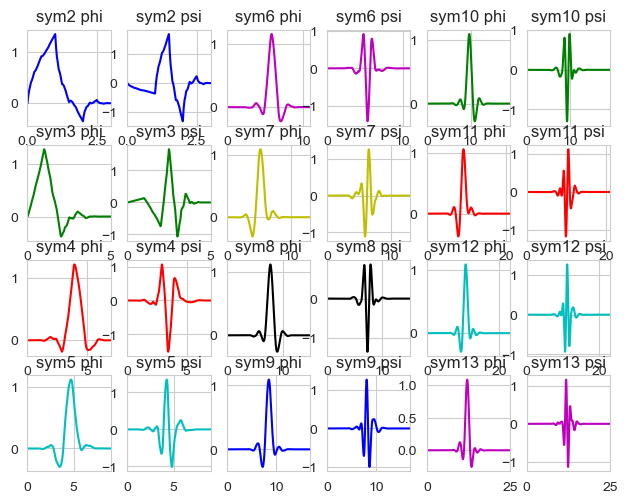

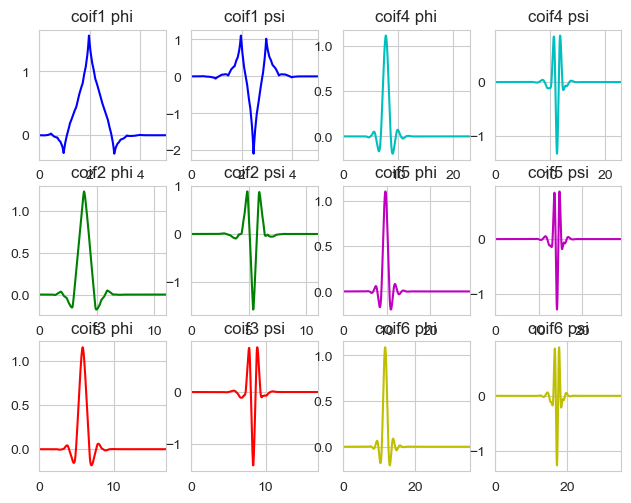

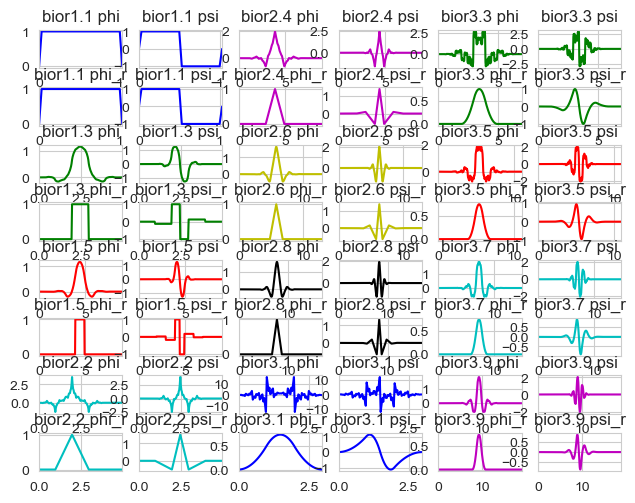

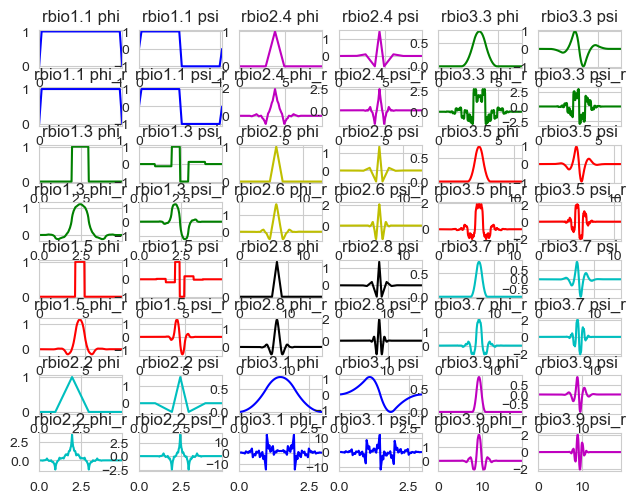

In [ ]:
# Plot scaling and wavelet functions for db, sym, coif, bior and rbio families

import itertools

import matplotlib.pyplot as plt

import pywt

plot_data = [('db', (4, 3)),
             ('sym', (4, 3)),
             ('coif', (3, 2))]


for family, (rows, cols) in plot_data:
    fig = plt.figure()
    fig.subplots_adjust(hspace=0.2, wspace=0.2, bottom=.02, left=.06,
                        right=.97, top=.94)
    colors = itertools.cycle('bgrcmyk')

    wnames = pywt.wavelist(family)
    i = iter(wnames)
    for col in range(cols):
        for row in range(rows):
            try:
                wavelet = pywt.Wavelet(next(i))
            except StopIteration:
                break
            phi, psi, x = wavelet.wavefun(level=5)

            color = next(colors)
            ax = fig.add_subplot(rows, 2 * cols, 1 + 2 * (col + row * cols))
            ax.set_title(wavelet.name + " phi")
            ax.plot(x, phi, color)
            ax.set_xlim(min(x), max(x))

            ax = fig.add_subplot(rows, 2*cols, 1 + 2*(col + row*cols) + 1)
            ax.set_title(wavelet.name + " psi")
            ax.plot(x, psi, color)
            ax.set_xlim(min(x), max(x))

for family, (rows, cols) in [('bior', (4, 3)), ('rbio', (4, 3))]:
    fig = plt.figure()
    fig.subplots_adjust(hspace=0.5, wspace=0.2, bottom=.02, left=.06,
                        right=.97, top=.94)

    colors = itertools.cycle('bgrcmyk')
    wnames = pywt.wavelist(family)
    i = iter(wnames)
    for col in range(cols):
        for row in range(rows):
            try:
                wavelet = pywt.Wavelet(next(i))
            except StopIteration:
                break
            phi, psi, phi_r, psi_r, x = wavelet.wavefun(level=5)
            row *= 2

            color = next(colors)
            ax = fig.add_subplot(2*rows, 2*cols, 1 + 2*(col + row*cols))
            ax.set_title(wavelet.name + " phi")
            ax.plot(x, phi, color)
            ax.set_xlim(min(x), max(x))

            ax = fig.add_subplot(2*rows, 2*cols, 2*(1 + col + row*cols))
            ax.set_title(wavelet.name + " psi")
            ax.plot(x, psi, color)
            ax.set_xlim(min(x), max(x))

            row += 1
            ax = fig.add_subplot(2*rows, 2*cols, 1 + 2*(col + row*cols))
            ax.set_title(wavelet.name + " phi_r")
            ax.plot(x, phi_r, color)
            ax.set_xlim(min(x), max(x))

            ax = fig.add_subplot(2*rows, 2*cols, 1 + 2*(col + row*cols) + 1)
            ax.set_title(wavelet.name + " psi_r")
            ax.plot(x, psi_r, color)
            ax.set_xlim(min(x), max(x))

In [ ]:
import pywt
import numpy as np

def wavelet_kernel(signal1, signal2, wavelet='db1', level=1):
    # Compute the wavelet decomposition of the signals
    coeffs1 = pywt.wavedec(signal1, wavelet, level=level)
    coeffs2 = pywt.wavedec(signal2, wavelet, level=level)

    # Compute the dot product between the corresponding wavelet coefficients
    kernel = np.zeros((len(coeffs1), len(coeffs2[0])))
    for i in range(len(coeffs1)):
        for j in range(len(coeffs2[0])):
            kernel[i, j] = np.dot(coeffs1[i], coeffs2[j])

    return kernel

# Example usage
signal1 = np.random.randn(100)
signal2 = np.random.randn(100)
kernel = wavelet_kernel(signal1, signal2, wavelet='db4', level=3)


In [ ]:
signal1.reshape(-1, 1).shape

(5, 1)

[[1.         1.         1.         0.99600799 1.         0.97530991
  1.        ]
 [1.         1.         1.         0.99600799 1.         0.97530991
  1.        ]
 [0.97530991 0.97530991 0.97530991 0.99104038 0.97530991 1.
  0.97530991]
 [1.         1.         1.         0.99600799 1.         0.97530991
  1.        ]
 [1.         1.         1.         0.99600799 1.         0.97530991
  1.        ]
 [1.         1.         1.         0.99600799 1.         0.97530991
  1.        ]
 [1.         1.         1.         0.99600799 1.         0.97530991
  1.        ]]


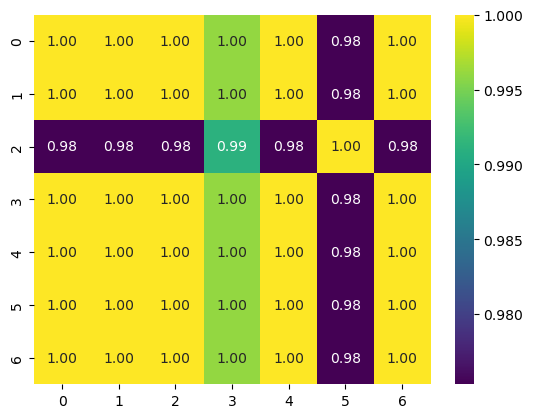

In [ ]:
import numpy as np
from sklearn.metrics.pairwise import rbf_kernel

# Generate two 1D signals
signal1 = np.array([1, 2, 3, 4, 5])
signal2 = np.array([1.5, 2.5, 3.5, 4.5, 5.5])

signal1 = np.array([1, 1, 1.5, 1, 1, 1, 1])
signal2 = np.array([1, 1, 1,   1.2, 1, 1.5, 1])

# Compute the RBF kernel matrix between the two signals
gamma = 0.1  # The gamma parameter of the RBF kernel
kernel_matrix = rbf_kernel(signal1.reshape(-1, 1), signal2.reshape(-1, 1), gamma=gamma)

# The resulting kernel_matrix contains the pairwise similarity scores between the two signals
print(kernel_matrix)

# Visualize the RBF kernel matrix as a heatmap
sns.heatmap(kernel_matrix, cmap='viridis', annot=True, fmt='.2f');

In [ ]:
names_mean

array(['LUI-0', 'LUI-1', 'LUI-2', 'LUI-3', 'SPA1-0', 'SPA1-1', 'SPA1-2',
       'SPA1-3', 'TM4.1-0', 'TM4.1-1', 'TM4.1-2', 'TM4.1-3'], dtype='<U7')

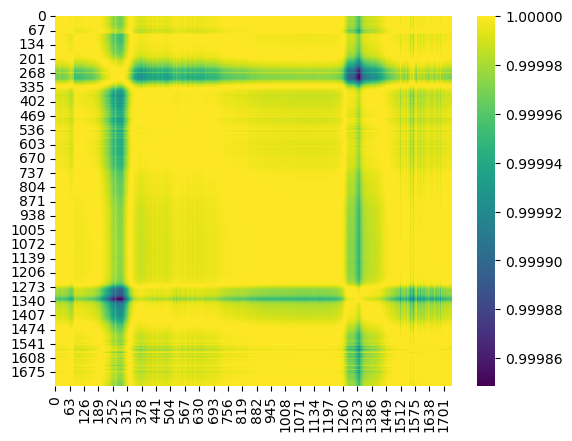

In [ ]:
x1, x2 = X_mean[8,:].reshape(-1,1), X_mean[11,:].reshape(-1,1) 

# Compute the RBF kernel matrix between the two signals
gamma = 0.1  # The gamma parameter of the RBF kernel
kernel_matrix = rbf_kernel(x2-x1, x2-x1, gamma=gamma)

# The resulting kernel_matrix contains the pairwise similarity scores between the two signals
# print(kernel_matrix)

# Visualize the RBF kernel matrix as a heatmap
sns.heatmap(kernel_matrix, cmap='viridis');

In [ ]:
wavenumbers

array([ 649.8933,  651.8218,  653.7502, ..., 3995.784 , 3997.712 ,
       3999.641 ])

<Figure size 640x480 with 0 Axes>

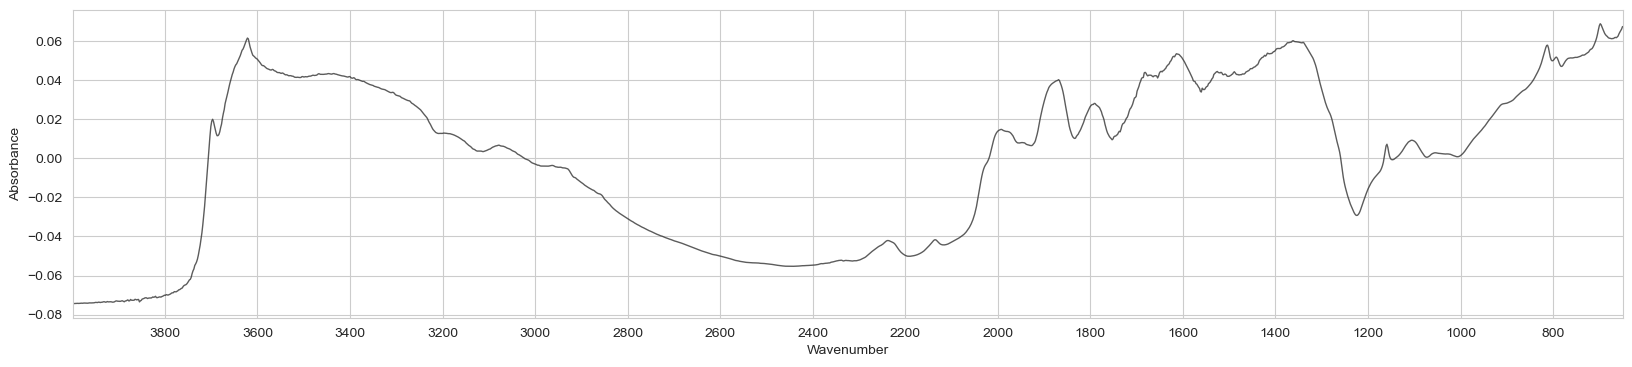

In [ ]:
plot_spectra(x1.ravel(), wavenumbers, ascending=False)

<Figure size 640x480 with 0 Axes>

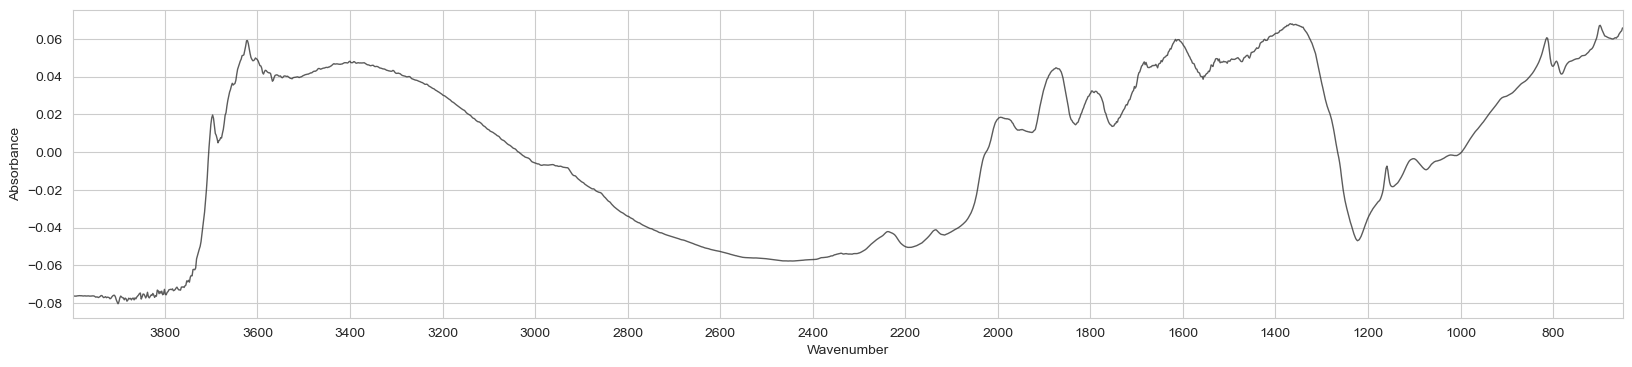

In [ ]:
plot_spectra(x2.ravel(), wavenumbers, ascending=False)

<Figure size 640x480 with 0 Axes>

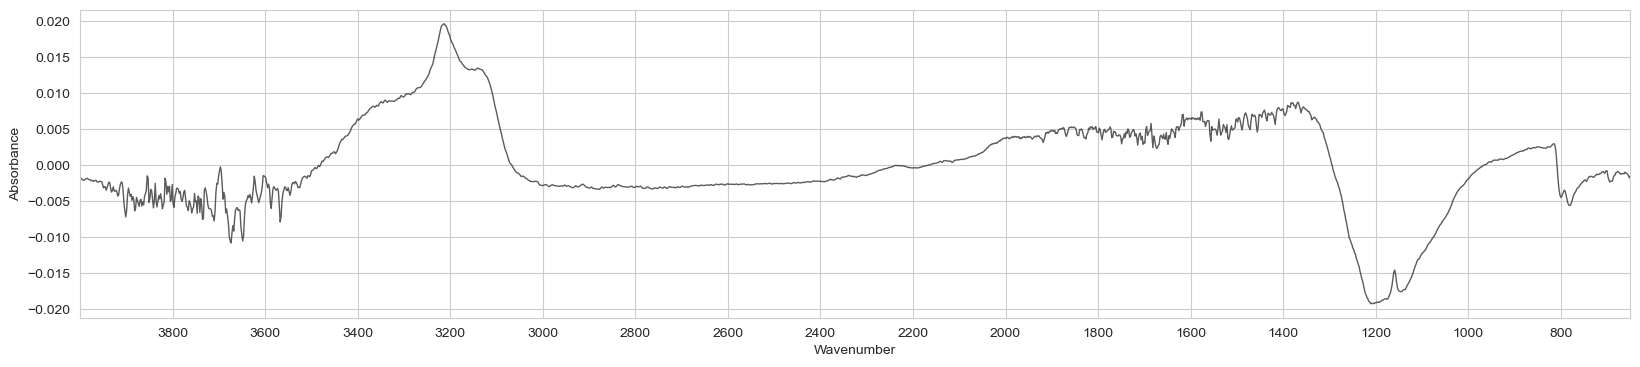

In [ ]:
plot_spectra((x2-x1).ravel(), wavenumbers, ascending=False)